# Build SET100 Dataset

1. Start from set100_union.csv  
2. Build table "stock"  
3. Build table "timeseries"  
4. Build table "set100_membership_periods"  


dataset/eikon-data  
SET_Price_2014-2020.xlsm  
SET_VA_2014-2020.xlsm  - TURNOVER BY VALUE  


In [1]:
import sys, os, os.path
if not 'EXPERIMENT_HOME' in os.environ: # Configure local paths if not already defined
    ML_HOME = os.path.abspath(os.path.join("..", "ml_home")) # ML workspace
    EXPERIMENT_HOME = os.path.abspath(os.path.join(ML_HOME, "..")) # Experiment workspace
    DATA_HOME = os.path.abspath(os.path.join(EXPERIMENT_HOME,"dataset")) # Dataset location
    os.environ["EXPERIMENT_HOME"] = EXPERIMENT_HOME
    os.environ["DATA_HOME"] = DATA_HOME
    sys.path.insert(0, EXPERIMENT_HOME)
    sys.path.insert(0, ML_HOME) # Add to path so can load our library
    os.chdir(EXPERIMENT_HOME) # Change working directory to experiment workspace
print("Experiment Home: ", os.path.abspath(os.curdir), "; Data Home:", DATA_HOME)

Experiment Home:  /home/jovyan ; Data Home: /home/jovyan/dataset


In [2]:
from datetime import datetime
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import xlrd
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv(os.path.join(DATA_HOME,"set100_union.csv"))
cols = df.columns
tickers = df[cols[1]]

In [3]:
tickers

0       CPALL
1      ADVANC
2       BLAND
3        GPSC
4         TTW
        ...  
158    SAMTEL
159       PSH
160        QH
161       SIM
162       AAV
Name: 0, Length: 163, dtype: object

In [4]:
os.chdir("/home/jovyan/dataset/eikon-data")

lookup = pd.read_csv('lookup-stock.csv')
lookup.tail()

,Unnamed: 0,ISIN,RIC,name,symbol
597,597,TH0788010005,TH:WORK,WORKPOINT ENTERTAINMENT,WORK
598,598,TH6073010Z01,TH:WP,WP ENERGY,WP
599,599,TH8220010004,TH:WPH,WATTANAPAT HOSPITAL TRANG,WPH
600,600,TH8962010006,TH:ZEN,ZEN CORPORATION,ZEN
601,601,TH0472B10Z01,TH:ZMICO,SEAMICO SECURITIES,ZMICO


In [5]:
lookup.loc[lookup['symbol']=='LHFG']

,Unnamed: 0,ISIN,RIC,name,symbol
256,256,TH1019010Y00,TH:LHFG,LH FINANCIAL GP.,LHFG


In [6]:
lookup.loc[lookup['symbol']=='SAPPE']

,Unnamed: 0,ISIN,RIC,name,symbol
400,400,TH5614010004,TH:SAPPE,SAPPE,SAPPE


# Price Series

In [7]:
def price_value(x):
    if x.value == 'NA':
        return None
    else:
        return float(x.value)

def get_price_series():
    fname = 'SET_Price_2014-2020.xlsm'
    wb = xlrd.open_workbook(fname)
    series = {}
    for i in range(2,8): # Note the sheet index 2014-2019
        s = wb.sheets()[i]

        # Date index
        s1 = pd.Series(s.col(0)[4:]) # observation starts at row 4
        s1 = s1.apply(lambda x: datetime(*xlrd.xldate_as_tuple(x.value, wb.datemode)))

        for j in range(1, s.ncols):
            c = s.col(j)
            print("{}".format(c[3].value))
            name = c[3].value
            # df = pd.DataFrame()
            if not "#ERROR" in name:
                # Convert spreadsheet value to python
                s2 = pd.Series(c[4:]) # observation starts at row 4
                s2 = s2.apply(price_value)
                df = pd.concat([s1, s2], axis=1)

                if not name in series:
                    series[name] = []
                series[name].append(df)
    return series

def rekey_and_stack(sin):
    sout = {}
    keys = series.keys()
    # Change key
    for k in keys:
        # newkey = k.replace(' - TURNOVER BY VALUE','')
        symbol = lookup.loc[lookup['name']==k].symbol.values[0]
        sout[symbol] = series[k]
    # Merge years
    for s in sout.keys():   
        stock = pd.concat(sout[s], axis=0)
        stock.columns = ['Date', 'Price']
        stock = stock.set_index('Date') # Set date index
        sout[s] = stock 
    return sout

series = get_price_series()
price_series = rekey_and_stack(series)
price_series['7UP']


SEVEN UTILITIES AND POWER ORS
AREEYA PROPERTY
ASIA AVIATION
AMATA B GRIMM PWPL.IFCF.
ADVANCED CONNECTION CORPORATION
ABSOLUTE CLEAN ENERGY
AUTOCORP HOLDING
ADVANCED INFO SER.
AEC SECURITIES
AE.THANA SINSAP (THAI.)
ASIA FIBER
AAPICO HITECH
AIKCHOL HOSPITAL
ASIAN INSULATORS
AIM COML.GW.FH.&. LH. REIT UNT.
AIM INDL.GW.FH.&. LH. REIT
ADVANCED INFO.TECH.
AJ PLAST
AJ ADVANCE TECHNOLOGY ORS
EKARAT ENGINEERING
ALLA
ALT TELECOM
ALUCON
AMANAH LEASING
AMARIN PRINTING & PBL.
AMATA
AMATA NVDR
AMATA VN
ASIA METAL
ANANDA DEVELOPMENT
AIRPORTS OF THAILAND
AP (THAILAND)
ASIAN PHYTOCEUTICALS
ASIA PRECISION
APEX DEVELOPMENT
AGRIPURE HOLDINGS
AQ ESTATE
AQUA
ASIASOFT
SYNERGETIC AUTO PERFORMANCE
ASEFA
ASIA HOTEL
ASIAN SEA CORPORATION
ASIAN MARINE SERVICES
ASIA SERMKIJ LEASING
ASIA PLUS GROUP HDG.
ASSET WORLD
ALLIANZ AYUDHYA CAPITAL
BUALUANG OFFE.LH. REIT.
BEGISTICS ORS
B-52 CAPITAL
BANGKOK AIRWAY
BGK.AVIATION FUEL SVS.
BANGKOK COMMERCIAL ASSET MANAGEMENT
BANPU
HITACHI CHEMICALSTORAGE BATTERY
BANK OF AYUDHYA


WYNCOAST INDUSTRIAL PARK
WORKPOINT ENTERTAINMENT
WP ENERGY
WATTANAPAT HOSPITAL TRANG
ZEN CORPORATION
SEAMICO SECURITIES
SEVEN UTILITIES AND POWER ORS
AREEYA PROPERTY
ASIA AVIATION
AMATA B GRIMM PWPL.IFCF.
ADVANCED CONNECTION CORPORATION
#ERROR
#ERROR
ADVANCED INFO SER.
AEC SECURITIES
AE.THANA SINSAP (THAI.)
ASIA FIBER
AAPICO HITECH
AIKCHOL HOSPITAL
ASIAN INSULATORS
#ERROR
AIM INDL.GW.FH.&. LH. REIT
ADVANCED INFO.TECH.
AJ PLAST
AJ ADVANCE TECHNOLOGY ORS
EKARAT ENGINEERING
ALLA
ALT TELECOM
ALUCON
AMANAH LEASING
AMARIN PRINTING & PBL.
AMATA
AMATA NVDR
AMATA VN
ASIA METAL
ANANDA DEVELOPMENT
AIRPORTS OF THAILAND
AP (THAILAND)
ASIAN PHYTOCEUTICALS
ASIA PRECISION
APEX DEVELOPMENT
AGRIPURE HOLDINGS
AQ ESTATE
AQUA
ASIASOFT
SYNERGETIC AUTO PERFORMANCE
ASEFA
ASIA HOTEL
ASIAN SEA CORPORATION
ASIAN MARINE SERVICES
ASIA SERMKIJ LEASING
ASIA PLUS GROUP HDG.
#ERROR
ALLIANZ AYUDHYA CAPITAL
BUALUANG OFFE.LH. REIT.
BEGISTICS ORS
B-52 CAPITAL
BANGKOK AIRWAY
BGK.AVIATION FUEL SVS.
#ERROR
BANPU
HITACHI CHEM

AMATA B GRIMM PWPL.IFCF.
ADVANCED CONNECTION CORPORATION
#ERROR
#ERROR
ADVANCED INFO SER.
AEC SECURITIES
AE.THANA SINSAP (THAI.)
ASIA FIBER
AAPICO HITECH
AIKCHOL HOSPITAL
ASIAN INSULATORS
#ERROR
#ERROR
ADVANCED INFO.TECH.
AJ PLAST
AJ ADVANCE TECHNOLOGY ORS
EKARAT ENGINEERING
ALLA
ALT TELECOM
ALUCON
AMANAH LEASING
AMARIN PRINTING & PBL.
AMATA
AMATA NVDR
AMATA VN
ASIA METAL
ANANDA DEVELOPMENT
AIRPORTS OF THAILAND
AP (THAILAND)
ASIAN PHYTOCEUTICALS
ASIA PRECISION
APEX DEVELOPMENT
AGRIPURE HOLDINGS
AQ ESTATE
AQUA
ASIASOFT
SYNERGETIC AUTO PERFORMANCE
ASEFA
ASIA HOTEL
ASIAN SEA CORPORATION
ASIAN MARINE SERVICES
ASIA SERMKIJ LEASING
ASIA PLUS GROUP HDG.
#ERROR
ALLIANZ AYUDHYA CAPITAL
#ERROR
BEGISTICS ORS
B-52 CAPITAL
BANGKOK AIRWAY
BGK.AVIATION FUEL SVS.
#ERROR
BANPU
HITACHI CHEMICALSTORAGE BATTERY
BANK OF AYUDHYA
BANGKOK BANK
BANGKOK CHAIN HOSPITAL
BANGCHAK CORPORATION ORS
BCPG
BIRLA CARBON
BANGKOK DUSIT MED.SVS.
BEAUTY COMMUNITY
BEC WORLD
BANGKOK EXPRESSWAY AND METRO
SRISAWAD FINANCE
#ERROR

WYNCOAST INDUSTRIAL PARK
WORKPOINT ENTERTAINMENT
#ERROR
WATTANAPAT HOSPITAL TRANG
#ERROR
SEAMICO SECURITIES
SEVEN UTILITIES AND POWER ORS
AREEYA PROPERTY
ASIA AVIATION
AMATA B GRIMM PWPL.IFCF.
ADVANCED CONNECTION CORPORATION
#ERROR
#ERROR
ADVANCED INFO SER.
AEC SECURITIES
AE.THANA SINSAP (THAI.)
ASIA FIBER
AAPICO HITECH
AIKCHOL HOSPITAL
ASIAN INSULATORS
#ERROR
#ERROR
ADVANCED INFO.TECH.
AJ PLAST
AJ ADVANCE TECHNOLOGY ORS
EKARAT ENGINEERING
ALLA
ALT TELECOM
ALUCON
AMANAH LEASING
AMARIN PRINTING & PBL.
AMATA
AMATA NVDR
AMATA VN
ASIA METAL
ANANDA DEVELOPMENT
AIRPORTS OF THAILAND
AP (THAILAND)
ASIAN PHYTOCEUTICALS
ASIA PRECISION
APEX DEVELOPMENT
AGRIPURE HOLDINGS
AQ ESTATE
AQUA
ASIASOFT
#ERROR
ASEFA
ASIA HOTEL
ASIAN SEA CORPORATION
ASIAN MARINE SERVICES
ASIA SERMKIJ LEASING
ASIA PLUS GROUP HDG.
#ERROR
ALLIANZ AYUDHYA CAPITAL
#ERROR
BEGISTICS ORS
B-52 CAPITAL
BANGKOK AIRWAY
BGK.AVIATION FUEL SVS.
#ERROR
BANPU
HITACHI CHEMICALSTORAGE BATTERY
BANK OF AYUDHYA
BANGKOK BANK
BANGKOK CHAIN HOSPITA

ASIA HOTEL
ASIAN SEA CORPORATION
ASIAN MARINE SERVICES
ASIA SERMKIJ LEASING
ASIA PLUS GROUP HDG.
#ERROR
ALLIANZ AYUDHYA CAPITAL
#ERROR
BEGISTICS ORS
B-52 CAPITAL
BANGKOK AIRWAY
BGK.AVIATION FUEL SVS.
#ERROR
BANPU
HITACHI CHEMICALSTORAGE BATTERY
BANK OF AYUDHYA
BANGKOK BANK
BANGKOK CHAIN HOSPITAL
BANGCHAK CORPORATION ORS
#ERROR
BIRLA CARBON
BANGKOK DUSIT MED.SVS.
BEAUTY COMMUNITY
BEC WORLD
#ERROR
SRISAWAD FINANCE
#ERROR
#ERROR
BUMRUNGRAD HOSPITAL
BIG CAMERA
BERLI JUCKER
BJC HEAVY INDUSTRIES
BANGKOK DEC-CON
#ERROR
BANGKOK INSURANCE
BANGKOK COMMERCIAL PROPERTY
BANGKOK LIFE ASSURANCE
BANGKOK LAND
#ERROR
#ERROR
BANGKOK RANCH
BAAN ROCK GARDEN
BURIRAM SUGAR
#ERROR
BANGSAPHAN BARMILL
BOUTIQUE NEW CITY
BTS GROUP HDG.
BTS RAL.MSTI.GW. INFR.
BANGKOK UNION IN.
BETTER WORLD GREEN
CARABAO GROUP
CAL-COMP ELTN.(THAI.)
CHONBURI CONC.PRODUCT
CAPITAL ENGR.NETWORK
CENTRAL PLAZA HOTEL
SEAFRESH INDUSTRY
COUNTRY GROUP DEV.
COUNTRY GROUP HOLDINGS
CHARAN INSURANCE
CHULARAT HOSPITAL
KGHSG.TRDG.FRZ.FOOD
CHARN IS

CHRISTIANI & NIELSEN
COL
#ERROR
#ERROR
CP ALL
CHAROEN POKPHAND FOODS
CASTLE PEAK HOLDINGS
CHUMPORN PALM OIL IND.
CPL GROUP
CENTRAL PATTANA
CPN COML.GW.LH.PR.
#ERROR
#ERROR
C P TOWER GROWTH LEASEHOLD PROPERTY
#ERROR
CHU KAI
#ERROR
CROWN SEAL
CSP STEEL CENTER
CITY SPORTS & RECREATION
COMMUNICATION & SYSTEM SOLUTION
CENTARA H&R.LH.PR.
CHAROONG THAI WIRE CAB.
CHAI WATANA TANNERY
DYNASTY CERAMIC
DCON PRODUCTS
#ERROR
DELTA ELECTRONICS
DEMCO
DIGITAL TELECOM.IFCF.
#ERROR
#ERROR
DIAMOND BLDG.PRODUCTS
TOTAL ACCESS COMMS.
DUSIT THANI
DTC INDUSTRIES
ENERGY ABSOLUTE
EASON &
EASTERN WATER RESOURCES DEV.& MAN.
EASTERN COML.LEASING
ETERNAL ENERGY
#ERROR
ELECTRICITY GENERATING
#ERROR
EMC
EASTERN POWER
EASTERN POLYMER GROUP
ERAWAN GROUP
ERAWAN HOTEL GROWTH PROPERTY
ESSO THAILAND
EASTERN STAR REAL ESTATE
EVERLAND
FOOD AND DRINKS
FANCY WOOD INDUSTRIES
FAR EAST FAME LINE DDB ORS
FURUKAWA METAL(THAILAND)
#ERROR
FINANSA
FORTH
FRASERS PROPERTY PUBLIC
FINANSIA SYRUS SECS.
#ERROR
#ERROR
FUTURE PARK LEASEHOLD PR

,Price
Date,
2019-01-01,0.44
2019-01-02,0.43
2019-01-03,0.43
2019-01-04,0.43
2019-01-07,0.42
...,...
2014-12-25,3.22
2014-12-26,3.24
2014-12-29,3.05


In [8]:
price = {}
for t in tickers:
    if t in price_series:
        # print("Has price data for %s" % t)
        price[t] = price_series[t]
    else:
        print("No price data for %s" % t)

No price data for TUF
No price data for HEMRAJ
No price data for BMCL
No price data for PS
No price data for EARTH
No price data for BIGC
No price data for ROBINS
No price data for BECL
No price data for BGH
No price data for GLOW
No price data for IFEC
No price data for TICON
No price data for SIM


In [9]:
len(price)

150

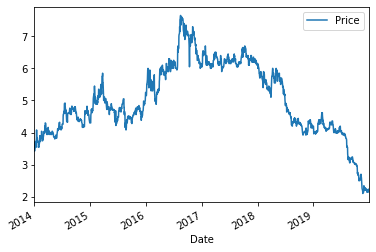

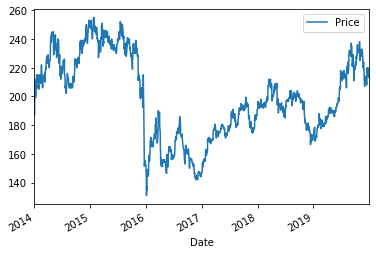

In [10]:
price['AAV'].plot()
price['ADVANC'].plot()

In [11]:
for k in sorted(price.keys()):
    print(k)

AAV
ADVANC
AEONTS
AMATA
ANAN
AOT
AP
ASP
AWC
BA
BANPU
BAY
BBL
BCH
BCP
BCPG
BDMS
BEAUTY
BEC
BEM
BGRIM
BH
BIG
BJC
BJCHI
BLA
BLAND
BPP
BTS
CBG
CENTEL
CHG
CK
CKP
COM7
CPALL
CPF
CPN
DELTA
DEMCO
DTAC
EA
EGCO
EPG
ERW
ESSO
GFPT
GGC
GL
GLOBAL
GOLD
GPSC
GULF
GUNKUL
HANA
HMPRO
ICHI
INTUCH
IRPC
ITD
IVL
JAS
JMART
JMT
JWD
KAMART
KBANK
KCE
KKP
KTB
KTC
KTIS
LH
LHFG
LOXLEY
LPN
M
MAJOR
MALEE
MBK
MC
MEGA
MINT
MONO
MTC
NOK
ORI
OSP
PLANB
PLAT
PRM
PSH
PSL
PTG
PTL
PTT
PTTEP
PTTGC
QH
RATCH
RS
S
SAMART
SAMTEL
SAPPE
SAWAD
SCB
SCC
SCCC
SCN
SF
SGP
SIRI
SPALI
SPCG
SPRC
STA
STEC
STPI
SUPER
SVI
TASCO
TCAP
THAI
THANI
THCOM
THREL
TISCO
TKN
TMB
TOA
TOP
TPIPL
TPIPP
TRC
TRUE
TTA
TTCL
TTW
TU
TVO
U
UNIQ
UV
VGI
VIBHA
VNG
WHA
WHAUP
WORK


# Turnover by Value

In [12]:
def get_VA_series():
    fname = 'SET_VA_2014-2020.xlsm'
    wb = xlrd.open_workbook(fname)
    series = {}
    for i in range(2,8): # Note the sheet index 2014-2019
        s = wb.sheets()[i]

        # Date index
        s1 = pd.Series(s.col(0)[4:]) # observation starts at row 4
        s1 = s1.apply(lambda x: datetime(*xlrd.xldate_as_tuple(x.value, wb.datemode)))

        for j in range(1, s.ncols):
            c = s.col(j)
            print("{}".format(c[3].value))
            name = c[3].value
            # df = pd.DataFrame()
            if not "#ERROR" in name:
                # Convert spreadsheet market cap value to python
                s2 = pd.Series(c[4:]) # observation starts at row 4
                s2 = s2.apply(lambda x: x.value)
                df = pd.concat([s1, s2], axis=1)

                if not name in series:
                    series[name] = []
                series[name].append(df)
    return series

def rekey_and_stack(sin):
    sout = {}
    keys = sin.keys()
    # Change key
    for k in keys:
        newkey = k.replace(' - TURNOVER BY VALUE','')
        symbol = lookup.loc[lookup['name']==newkey].symbol.values[0]
        sout[symbol] = sin[k]
    # Merge years
    for s in sout.keys():   
        stock = pd.concat(sout[s], axis=0)
        stock.columns = ['Date', 'VA']
        stock = stock.set_index('Date') # Set date index
        sout[s] = stock 
    return sout

va = get_VA_series()
turnover_by_value = rekey_and_stack(va)

SEVEN UTILITIES AND POWER ORS - TURNOVER BY VALUE
AREEYA PROPERTY - TURNOVER BY VALUE
ASIA AVIATION - TURNOVER BY VALUE
AMATA B GRIMM PWPL.IFCF. - TURNOVER BY VALUE
ADVANCED CONNECTION CORPORATION - TURNOVER BY VALUE
ABSOLUTE CLEAN ENERGY - TURNOVER BY VALUE
AUTOCORP HOLDING - TURNOVER BY VALUE
ADVANCED INFO SER. - TURNOVER BY VALUE
AEC SECURITIES - TURNOVER BY VALUE
AE.THANA SINSAP (THAI.) - TURNOVER BY VALUE
ASIA FIBER - TURNOVER BY VALUE
AAPICO HITECH - TURNOVER BY VALUE
AIKCHOL HOSPITAL - TURNOVER BY VALUE
ASIAN INSULATORS - TURNOVER BY VALUE
AIM COML.GW.FH.&. LH. REIT UNT. - TURNOVER BY VALUE
AIM INDL.GW.FH.&. LH. REIT - TURNOVER BY VALUE
ADVANCED INFO.TECH. - TURNOVER BY VALUE
AJ PLAST - TURNOVER BY VALUE
AJ ADVANCE TECHNOLOGY ORS - TURNOVER BY VALUE
EKARAT ENGINEERING - TURNOVER BY VALUE
ALLA - TURNOVER BY VALUE
ALT TELECOM - TURNOVER BY VALUE
ALUCON - TURNOVER BY VALUE
AMANAH LEASING - TURNOVER BY VALUE
AMARIN PRINTING & PBL. - TURNOVER BY VALUE
AMATA - TURNOVER BY VALUE
AMATA 

MONO TECHNOLOGY - TURNOVER BY VALUE
M PICTURES ENTERTAINMENT - TURNOVER BY VALUE
METRO SYSTEMS - TURNOVER BY VALUE
MUANGTHAI CAPITAL ORS - TURNOVER BY VALUE
MUANG THAI INSURANCE - TURNOVER BY VALUE
NEW CITY (BANGKOK) - TURNOVER BY VALUE
NC HOUSING - TURNOVER BY VALUE
NEP REALTY & IND. - TURNOVER BY VALUE
NORTH EAST RUBBERS - TURNOVER BY VALUE
WATTANA KARNPAET - TURNOVER BY VALUE
NEX POINT - TURNOVER BY VALUE
NFC - TURNOVER BY VALUE
NAVAKIJ INSURANCE - TURNOVER BY VALUE
NAVANAKORN - TURNOVER BY VALUE
NOBLE DEVELOPMENT - TURNOVER BY VALUE
NOK AIRLINES - TURNOVER BY VALUE
NAM SENG INSURANCE - TURNOVER BY VALUE
NONTHAVEJ HOSPITAL - TURNOVER BY VALUE
NUSASIRI - TURNOVER BY VALUE
NIRVANA DAII ORS - TURNOVER BY VALUE
NAWARAT PATANAKARN - TURNOVER BY VALUE
NAMYONG TERMINAL - TURNOVER BY VALUE
OCC - TURNOVER BY VALUE
OCEAN GLASS - TURNOVER BY VALUE
OHTL - TURNOVER BY VALUE
OISHI GROUP - TURNOVER BY VALUE
ORIGIN PROPERTY - TURNOVER BY VALUE
OSOTSPA - TURNOVER BY VALUE
PAN ASIA FOOTWEAR - TURNOVE

#ERROR
#ERROR
AIM INDL.GW.FH.&. LH. REIT - TURNOVER BY VALUE
ADVANCED INFO.TECH. - TURNOVER BY VALUE
AJ PLAST - TURNOVER BY VALUE
AJ ADVANCE TECHNOLOGY ORS - TURNOVER BY VALUE
EKARAT ENGINEERING - TURNOVER BY VALUE
ALLA - TURNOVER BY VALUE
ALT TELECOM - TURNOVER BY VALUE
ALUCON - TURNOVER BY VALUE
AMANAH LEASING - TURNOVER BY VALUE
AMARIN PRINTING & PBL. - TURNOVER BY VALUE
AMATA - TURNOVER BY VALUE
AMATA NVDR - TURNOVER BY VALUE
AMATA VN - TURNOVER BY VALUE
ASIA METAL - TURNOVER BY VALUE
ANANDA DEVELOPMENT - TURNOVER BY VALUE
AIRPORTS OF THAILAND - TURNOVER BY VALUE
AP (THAILAND) - TURNOVER BY VALUE
ASIAN PHYTOCEUTICALS - TURNOVER BY VALUE
ASIA PRECISION - TURNOVER BY VALUE
APEX DEVELOPMENT - TURNOVER BY VALUE
AGRIPURE HOLDINGS - TURNOVER BY VALUE
AQ ESTATE - TURNOVER BY VALUE
AQUA - TURNOVER BY VALUE
ASIASOFT - TURNOVER BY VALUE
SYNERGETIC AUTO PERFORMANCE - TURNOVER BY VALUE
ASEFA - TURNOVER BY VALUE
ASIA HOTEL - TURNOVER BY VALUE
ASIAN SEA CORPORATION - TURNOVER BY VALUE
ASIAN MARI

OISHI GROUP - TURNOVER BY VALUE
ORIGIN PROPERTY - TURNOVER BY VALUE
OSOTSPA - TURNOVER BY VALUE
PAN ASIA FOOTWEAR - TURNOVER BY VALUE
PACIFIC PIPE - TURNOVER BY VALUE
PATO CHEMICAL IND. - TURNOVER BY VALUE
PRESIDENT BAKERY - TURNOVER BY VALUE
PCS MACHINE GPHD. - TURNOVER BY VALUE
PADAENG INDUSTRY - TURNOVER BY VALUE
PRANDA JEWELRY - TURNOVER BY VALUE
PERMSIN STEEL WORKS - TURNOVER BY VALUE
PROPERTY PERFECT - TURNOVER BY VALUE
PEOPLE'S GARMENT - TURNOVER BY VALUE
PATKOL - TURNOVER BY VALUE
PHATRA LEASING - TURNOVER BY VALUE
PLAN B MEDIA - TURNOVER BY VALUE
THE PLATINUM GROUP - TURNOVER BY VALUE
POWER LINE ENGR. - TURNOVER BY VALUE
PREMIER MARKETING - TURNOVER BY VALUE
PM THORESEN ASIA HDG. - TURNOVER BY VALUE
PRI.OFFE.LH.PPF. REIT - TURNOVER BY VALUE
SAHATHAI TERMINAL - TURNOVER BY VALUE
BANGKOK POST ORS - TURNOVER BY VALUE
PINTHONG INDUSTRIAL PARK PROPERTY - TURNOVER BY VALUE
PREMIER PRODUCTS - TURNOVER BY VALUE
PP PRIME - TURNOVER BY VALUE
PRARAM 9 HOSPITAL - TURNOVER BY VALUE
PRAKIT 

ASIA HOTEL - TURNOVER BY VALUE
ASIAN SEA CORPORATION - TURNOVER BY VALUE
ASIAN MARINE SERVICES - TURNOVER BY VALUE
ASIA SERMKIJ LEASING - TURNOVER BY VALUE
ASIA PLUS GROUP HDG. - TURNOVER BY VALUE
#ERROR
ALLIANZ AYUDHYA CAPITAL - TURNOVER BY VALUE
#ERROR
BEGISTICS ORS - TURNOVER BY VALUE
B-52 CAPITAL - TURNOVER BY VALUE
BANGKOK AIRWAY - TURNOVER BY VALUE
BGK.AVIATION FUEL SVS. - TURNOVER BY VALUE
#ERROR
BANPU - TURNOVER BY VALUE
HITACHI CHEMICALSTORAGE BATTERY - TURNOVER BY VALUE
BANK OF AYUDHYA - TURNOVER BY VALUE
BANGKOK BANK - TURNOVER BY VALUE
BANGKOK CHAIN HOSPITAL - TURNOVER BY VALUE
BANGCHAK CORPORATION ORS - TURNOVER BY VALUE
BCPG - TURNOVER BY VALUE
BIRLA CARBON - TURNOVER BY VALUE
BANGKOK DUSIT MED.SVS. - TURNOVER BY VALUE
BEAUTY COMMUNITY - TURNOVER BY VALUE
BEC WORLD - TURNOVER BY VALUE
BANGKOK EXPRESSWAY AND METRO - TURNOVER BY VALUE
SRISAWAD FINANCE - TURNOVER BY VALUE
#ERROR
B GRIMM POWER - TURNOVER BY VALUE
BUMRUNGRAD HOSPITAL - TURNOVER BY VALUE
BIG CAMERA - TURNOVER B

PRINSIRI - TURNOVER BY VALUE
PRINCIPAL CAPITAL - TURNOVER BY VALUE
PRIMA MARINE - TURNOVER BY VALUE
PRUKSA HOLDING - TURNOVER BY VALUE
PRECIOUS SHIPPING - TURNOVER BY VALUE
PREMIER TECHNOLOGY - TURNOVER BY VALUE
PTG ENERGY - TURNOVER BY VALUE
POLYPLEX (THAILAND) - TURNOVER BY VALUE
PTT - TURNOVER BY VALUE
PTT EXPLORATION & PRDN. - TURNOVER BY VALUE
PTT GLOBAL CHEMICAL - TURNOVER BY VALUE
PYLON - TURNOVER BY VALUE
QUALITY CON.PRDS. - TURNOVER BY VALUE
QUALITY HOUSES - TURNOVER BY VALUE
QLT.HSE.HLRS.FH &. LH PROP - TURNOVER BY VALUE
QUALITY HOSPITALITY LEASEHOLD PROPERTY - TURNOVER BY VALUE
QUALITY HOUSES LEASEHOLD PROPERTY FU - TURNOVER BY VALUE
RAMKHAMHAENG HOSPITAL - TURNOVER BY VALUE
RATCH GROUP PCL - TURNOVER BY VALUE
#ERROR
ROYAL CERAMIC IND. - TURNOVER BY VALUE
REGIONAL CONTAINERS LIN. - TURNOVER BY VALUE
RICHY PLACE 2002 - TURNOVER BY VALUE
RAJTHANEE HOSPITAL PUBLIC - TURNOVER BY VALUE
RAIMON LAND - TURNOVER BY VALUE
ROCKWORTH - TURNOVER BY VALUE
ROYAL ORCHID HTL.(THAI.) - TURNOV

BAAN ROCK GARDEN - TURNOVER BY VALUE
BURIRAM SUGAR - TURNOVER BY VALUE
#ERROR
BANGSAPHAN BARMILL - TURNOVER BY VALUE
BOUTIQUE NEW CITY - TURNOVER BY VALUE
BTS GROUP HDG. - TURNOVER BY VALUE
BTS RAL.MSTI.GW. INFR. - TURNOVER BY VALUE
#ERROR
BETTER WORLD GREEN - TURNOVER BY VALUE
CARABAO GROUP - TURNOVER BY VALUE
CAL-COMP ELTN.(THAI.) - TURNOVER BY VALUE
CHONBURI CONC.PRODUCT - TURNOVER BY VALUE
CAPITAL ENGR.NETWORK - TURNOVER BY VALUE
CENTRAL PLAZA HOTEL - TURNOVER BY VALUE
SEAFRESH INDUSTRY - TURNOVER BY VALUE
COUNTRY GROUP DEV. - TURNOVER BY VALUE
COUNTRY GROUP HOLDINGS - TURNOVER BY VALUE
CHARAN INSURANCE - TURNOVER BY VALUE
CHULARAT HOSPITAL - TURNOVER BY VALUE
KGHSG.TRDG.FRZ.FOOD - TURNOVER BY VALUE
CHARN ISSARA DEVELOPMENT - TURNOVER BY VALUE
CIMB THAI BANK - TURNOVER BY VALUE
CITY STEEL - TURNOVER BY VALUE
CH KARNCHANG - TURNOVER BY VALUE
CK POWER - TURNOVER BY VALUE
CHIANGMAI FRZ.FOODS - TURNOVER BY VALUE
#ERROR
CHIANG MAI RAM MED.BUS. - TURNOVER BY VALUE
CHRISTIANI & NIELSEN - 

SAHACOGEN(CHONBURI) - TURNOVER BY VALUE
SCI ELECTRIC - TURNOVER BY VALUE
SCAN INTER - TURNOVER BY VALUE
SOUTHERN CONCRETE PILE - TURNOVER BY VALUE
SAMART DIGITAL ORS - TURNOVER BY VALUE
SE-EDUCATION - TURNOVER BY VALUE
SEAFCO - TURNOVER BY VALUE
#ERROR
SENA DEVELOPMENT - TURNOVER BY VALUE
SIAM FUTURE DEVELOPMENT - TURNOVER BY VALUE
#ERROR
SIAM FOOD PRODUCTS - TURNOVER BY VALUE
SIAMGAS AND PETROCHEM. - TURNOVER BY VALUE
SHANGRI-LA HOTEL - TURNOVER BY VALUE
#ERROR
#ERROR
SIAM STEEL INTL. - TURNOVER BY VALUE
SINGER THAILAND - TURNOVER BY VALUE
SANSIRI - TURNOVER BY VALUE
SIRI PRIME OFFICE PROPERTY - TURNOVER BY VALUE
SIS DS.(THAILAND) - TURNOVER BY VALUE
#ERROR
SRITHAI SUPERWARE - TURNOVER BY VALUE
#ERROR
#ERROR
SIKARIN - TURNOVER BY VALUE
SALEE PRINTING - TURNOVER BY VALUE
SAHAMIT MACHINERY - TURNOVER BY VALUE
SYN MUN KONG - TURNOVER BY VALUE
SAHAMITR PRESSURE CTNR. - TURNOVER BY VALUE
STARS MICROELECTRONICS - TURNOVER BY VALUE
SNC FORMER - TURNOVER BY VALUE
S & P SYNDICATE - TURNOVER BY

#ERROR
EMC - TURNOVER BY VALUE
EASTERN POWER - TURNOVER BY VALUE
EASTERN POLYMER GROUP - TURNOVER BY VALUE
ERAWAN GROUP - TURNOVER BY VALUE
ERAWAN HOTEL GROWTH PROPERTY - TURNOVER BY VALUE
ESSO THAILAND - TURNOVER BY VALUE
EASTERN STAR REAL ESTATE - TURNOVER BY VALUE
EVERLAND - TURNOVER BY VALUE
FOOD AND DRINKS - TURNOVER BY VALUE
FANCY WOOD INDUSTRIES - TURNOVER BY VALUE
FAR EAST FAME LINE DDB ORS - TURNOVER BY VALUE
FURUKAWA METAL(THAILAND) - TURNOVER BY VALUE
#ERROR
FINANSA - TURNOVER BY VALUE
FORTH - TURNOVER BY VALUE
FRASERS PROPERTY PUBLIC - TURNOVER BY VALUE
FINANSIA SYRUS SECS. - TURNOVER BY VALUE
#ERROR
FRASERS PROP THA INDUST FHLH.REIT - TURNOVER BY VALUE
FUTURE PARK LEASEHOLD PROPERTY - TURNOVER BY VALUE
#ERROR
GLOBLEX HOLDING - TURNOVER BY VALUE
GLOBAL CONNECTIONS - TURNOVER BY VALUE
GENERAL ENGINEERING - TURNOVER BY VALUE
GENERAL ENV.CVT. - TURNOVER BY VALUE
GFPT - TURNOVER BY VALUE
#ERROR
GRATITUDE INFINITE - TURNOVER BY VALUE
G J STEEL - TURNOVER BY VALUE
GROUP LEASE - T

THANACHART CAPITAL - TURNOVER BY VALUE
THAI CAPITAL - TURNOVER BY VALUE
THAI CENTRAL CHM. - TURNOVER BY VALUE
TCJ ASIA - TURNOVER BY VALUE
TCM CORPORATION ORS - TURNOVER BY VALUE
THAI COATING INDL. - TURNOVER BY VALUE
TEAM PRECISION - TURNOVER BY VALUE
#ERROR
#ERROR
THAIFOODS GROUP - TURNOVER BY VALUE
THAI FILM INDUSTRIES - TURNOVER BY VALUE
#ERROR
THAI-GERMAN PRODUCTS - TURNOVER BY VALUE
TONG HUA HOLDING - TURNOVER BY VALUE
THAI AIRWAYS INTL. - TURNOVER BY VALUE
RATCHTHANI LEASING - TURNOVER BY VALUE
THAICOM - TURNOVER BY VALUE
STEEL - TURNOVER BY VALUE
#ERROR
THANTAWAN INDUSTRY - TURNOVER BY VALUE
THAI REINSURANCE - TURNOVER BY VALUE
THAIRE LIFE ASSURANCE - TURNOVER BY VALUE
THAI INDUSTRIAL 1 - TURNOVER BY VALUE
DHIPAYA INSURANCE - TURNOVER BY VALUE
TIPCO FOODS - TURNOVER BY VALUE
TISCO FINANCIAL GROUP - TURNOVER BY VALUE
THAILAND IRON WORKS - TURNOVER BY VALUE
THITIKORN - TURNOVER BY VALUE
TAOKAENOI FOOD & MKTG. - TURNOVER BY VALUE
TKS TECHNOLOGIES - TURNOVER BY VALUE
T KRUNGTHAI IN

KCE ELECTRONICS - TURNOVER BY VALUE
THONBURI MEDICAL CENTRE - TURNOVER BY VALUE
KGI SECURITIES - TURNOVER BY VALUE
KULTHORN KIRBY - TURNOVER BY VALUE
KIATNAKIN BANK - TURNOVER BY VALUE
KPN PROPERTY - TURNOVER BY VALUE
KHON KAEN SUGAR - TURNOVER BY VALUE
KRUNG THAI BANK - TURNOVER BY VALUE
KRUNGTHAI CARD - TURNOVER BY VALUE
KASET THAI INTERNATIONAL SUG. - TURNOVER BY VALUE
KRUNGDHEP SOPHON - TURNOVER BY VALUE
KING WAI GROUP - TURNOVER BY VALUE
KANG YONG ELECTRIC - TURNOVER BY VALUE
LIGHTING & EQUIPMENT - TURNOVER BY VALUE
LALIN PROPERTY - TURNOVER BY VALUE
LANNA RESOURCES - TURNOVER BY VALUE
LEE FEED MILL - TURNOVER BY VALUE
LAND AND HOUSES - TURNOVER BY VALUE
LH FINANCIAL GP. - TURNOVER BY VALUE
#ERROR
LOHAKIT METAL - TURNOVER BY VALUE
LD.&.HSES.FH.AND LH.PR. - TURNOVER BY VALUE
LH SHOPPING CENTERS LEASEHOLD REIT - TURNOVER BY VALUE
LOXLEY - TURNOVER BY VALUE
#ERROR
LPN DEVELOPMENT - TURNOVER BY VALUE
LAGUNA RESORTS & HOTELS - TURNOVER BY VALUE
LAM SOON - TURNOVER BY VALUE
LUXURY REAL 

VANACHAI GROUP - TURNOVER BY VALUE
VINYTHAI - TURNOVER BY VALUE
VICHITBHAN PALMOIL - TURNOVER BY VALUE
#ERROR
WOW FACTOR - TURNOVER BY VALUE
THAI WACOAL - TURNOVER BY VALUE
WAVE ENTERTAINMENT - TURNOVER BY VALUE
WHITE GROUP - TURNOVER BY VALUE
WHA - TURNOVER BY VALUE
#ERROR
WHA PRUM.GW.FH.&. LH. REIT - TURNOVER BY VALUE
#ERROR
#ERROR
WIIK - TURNOVER BY VALUE
WYNCOAST INDUSTRIAL PARK - TURNOVER BY VALUE
WORKPOINT ENTERTAINMENT - TURNOVER BY VALUE
#ERROR
#ERROR
#ERROR
SEAMICO SECURITIES - TURNOVER BY VALUE


In [13]:
turnover_va = {}
for t in tickers:
    if t in turnover_by_value:
        # print("Has price data for %s" % t)
        turnover_va[t] = turnover_by_value[t]
    else:
        print("No VA data for %s" % t)

No VA data for TUF
No VA data for HEMRAJ
No VA data for BMCL
No VA data for PS
No VA data for EARTH
No VA data for BIGC
No VA data for ROBINS
No VA data for BECL
No VA data for BGH
No VA data for GLOW
No VA data for IFEC
No VA data for TICON
No VA data for SIM


# Turnover by Volume

In [14]:
def get_VO_series():
    fname = 'SET_VO_2014-2020.xlsm'
    wb = xlrd.open_workbook(fname)
    series = {}
    for i in range(2,8): # Note the sheet index 2014-2019
        s = wb.sheets()[i]

        # Date index
        s1 = pd.Series(s.col(0)[4:]) # observation starts at row 4
        s1 = s1.apply(lambda x: datetime(*xlrd.xldate_as_tuple(x.value, wb.datemode)))

        for j in range(1, s.ncols):
            c = s.col(j)
            print("{}".format(c[3].value))
            name = c[3].value
            # df = pd.DataFrame()
            if not "#ERROR" in name:
                # Convert spreadsheet market cap value to python
                s2 = pd.Series(c[4:]) # observation starts at row 4
                s2 = s2.apply(lambda x: x.value)
                df = pd.concat([s1, s2], axis=1)

                if not name in series:
                    series[name] = []
                series[name].append(df)
    return series

def rekey_and_stack(sin):
    sout = {}
    keys = sin.keys()
    # Change key
    for k in keys:
        newkey = k.replace(' - TURNOVER BY VOLUME','')
        symbol = lookup.loc[lookup['name']==newkey].symbol.values[0]
        sout[symbol] = sin[k]
    # Merge years
    for s in sout.keys():   
        stock = pd.concat(sout[s], axis=0)
        stock.columns = ['Date', 'VO']
        stock = stock.set_index('Date') # Set date index
        sout[s] = stock 
    return sout


vo = get_VO_series()
turnover_by_volume = rekey_and_stack(vo)

SEVEN UTILITIES AND POWER ORS - TURNOVER BY VOLUME
AREEYA PROPERTY - TURNOVER BY VOLUME
ASIA AVIATION - TURNOVER BY VOLUME
AMATA B GRIMM PWPL.IFCF. - TURNOVER BY VOLUME
ADVANCED CONNECTION CORPORATION - TURNOVER BY VOLUME
ABSOLUTE CLEAN ENERGY - TURNOVER BY VOLUME
AUTOCORP HOLDING - TURNOVER BY VOLUME
ADVANCED INFO SER. - TURNOVER BY VOLUME
AEC SECURITIES - TURNOVER BY VOLUME
AE.THANA SINSAP (THAI.) - TURNOVER BY VOLUME
ASIA FIBER - TURNOVER BY VOLUME
AAPICO HITECH - TURNOVER BY VOLUME
AIKCHOL HOSPITAL - TURNOVER BY VOLUME
ASIAN INSULATORS - TURNOVER BY VOLUME
AIM COML.GW.FH.&. LH. REIT UNT. - TURNOVER BY VOLUME
AIM INDL.GW.FH.&. LH. REIT - TURNOVER BY VOLUME
ADVANCED INFO.TECH. - TURNOVER BY VOLUME
AJ PLAST - TURNOVER BY VOLUME
AJ ADVANCE TECHNOLOGY ORS - TURNOVER BY VOLUME
EKARAT ENGINEERING - TURNOVER BY VOLUME
ALLA - TURNOVER BY VOLUME
ALT TELECOM - TURNOVER BY VOLUME
ALUCON - TURNOVER BY VOLUME
AMANAH LEASING - TURNOVER BY VOLUME
AMARIN PRINTING & PBL. - TURNOVER BY VOLUME
AMATA -

METRO SYSTEMS - TURNOVER BY VOLUME
MUANGTHAI CAPITAL ORS - TURNOVER BY VOLUME
MUANG THAI INSURANCE - TURNOVER BY VOLUME
NEW CITY (BANGKOK) - TURNOVER BY VOLUME
NC HOUSING - TURNOVER BY VOLUME
NEP REALTY & IND. - TURNOVER BY VOLUME
NORTH EAST RUBBERS - TURNOVER BY VOLUME
WATTANA KARNPAET - TURNOVER BY VOLUME
NEX POINT - TURNOVER BY VOLUME
NFC - TURNOVER BY VOLUME
NAVAKIJ INSURANCE - TURNOVER BY VOLUME
NAVANAKORN - TURNOVER BY VOLUME
NOBLE DEVELOPMENT - TURNOVER BY VOLUME
NOK AIRLINES - TURNOVER BY VOLUME
NAM SENG INSURANCE - TURNOVER BY VOLUME
NONTHAVEJ HOSPITAL - TURNOVER BY VOLUME
NUSASIRI - TURNOVER BY VOLUME
NIRVANA DAII ORS - TURNOVER BY VOLUME
NAWARAT PATANAKARN - TURNOVER BY VOLUME
NAMYONG TERMINAL - TURNOVER BY VOLUME
OCC - TURNOVER BY VOLUME
OCEAN GLASS - TURNOVER BY VOLUME
OHTL - TURNOVER BY VOLUME
OISHI GROUP - TURNOVER BY VOLUME
ORIGIN PROPERTY - TURNOVER BY VOLUME
OSOTSPA - TURNOVER BY VOLUME
PAN ASIA FOOTWEAR - TURNOVER BY VOLUME
PACIFIC PIPE - TURNOVER BY VOLUME
PATO CHEM

ASIA FIBER - TURNOVER BY VOLUME
AAPICO HITECH - TURNOVER BY VOLUME
AIKCHOL HOSPITAL - TURNOVER BY VOLUME
#ERROR
#ERROR
AIM INDL.GW.FH.&. LH. REIT - TURNOVER BY VOLUME
ADVANCED INFO.TECH. - TURNOVER BY VOLUME
AJ PLAST - TURNOVER BY VOLUME
AJ ADVANCE TECHNOLOGY ORS - TURNOVER BY VOLUME
EKARAT ENGINEERING - TURNOVER BY VOLUME
ALLA - TURNOVER BY VOLUME
ALT TELECOM - TURNOVER BY VOLUME
ALUCON - TURNOVER BY VOLUME
AMANAH LEASING - TURNOVER BY VOLUME
AMARIN PRINTING & PBL. - TURNOVER BY VOLUME
AMATA - TURNOVER BY VOLUME
AMATA NVDR - TURNOVER BY VOLUME
AMATA VN - TURNOVER BY VOLUME
ASIA METAL - TURNOVER BY VOLUME
ANANDA DEVELOPMENT - TURNOVER BY VOLUME
AIRPORTS OF THAILAND - TURNOVER BY VOLUME
AP (THAILAND) - TURNOVER BY VOLUME
ASIAN PHYTOCEUTICALS - TURNOVER BY VOLUME
ASIA PRECISION - TURNOVER BY VOLUME
APEX DEVELOPMENT - TURNOVER BY VOLUME
AGRIPURE HOLDINGS - TURNOVER BY VOLUME
AQ ESTATE - TURNOVER BY VOLUME
AQUA - TURNOVER BY VOLUME
ASIASOFT - TURNOVER BY VOLUME
SYNERGETIC AUTO PERFORMANCE 

NAMYONG TERMINAL - TURNOVER BY VOLUME
OCC - TURNOVER BY VOLUME
OCEAN GLASS - TURNOVER BY VOLUME
OHTL - TURNOVER BY VOLUME
OISHI GROUP - TURNOVER BY VOLUME
ORIGIN PROPERTY - TURNOVER BY VOLUME
OSOTSPA - TURNOVER BY VOLUME
PAN ASIA FOOTWEAR - TURNOVER BY VOLUME
PACIFIC PIPE - TURNOVER BY VOLUME
PATO CHEMICAL IND. - TURNOVER BY VOLUME
PRESIDENT BAKERY - TURNOVER BY VOLUME
PCS MACHINE GPHD. - TURNOVER BY VOLUME
PADAENG INDUSTRY - TURNOVER BY VOLUME
PRANDA JEWELRY - TURNOVER BY VOLUME
PERMSIN STEEL WORKS - TURNOVER BY VOLUME
PROPERTY PERFECT - TURNOVER BY VOLUME
PEOPLE'S GARMENT - TURNOVER BY VOLUME
PATKOL - TURNOVER BY VOLUME
PHATRA LEASING - TURNOVER BY VOLUME
PLAN B MEDIA - TURNOVER BY VOLUME
THE PLATINUM GROUP - TURNOVER BY VOLUME
POWER LINE ENGR. - TURNOVER BY VOLUME
PREMIER MARKETING - TURNOVER BY VOLUME
PM THORESEN ASIA HDG. - TURNOVER BY VOLUME
PRI.OFFE.LH.PPF. REIT - TURNOVER BY VOLUME
SAHATHAI TERMINAL - TURNOVER BY VOLUME
BANGKOK POST ORS - TURNOVER BY VOLUME
PINTHONG INDUSTRIAL 

ASIAN MARINE SERVICES - TURNOVER BY VOLUME
ASIA SERMKIJ LEASING - TURNOVER BY VOLUME
ASIA PLUS GROUP HDG. - TURNOVER BY VOLUME
#ERROR
ALLIANZ AYUDHYA CAPITAL - TURNOVER BY VOLUME
#ERROR
BEGISTICS ORS - TURNOVER BY VOLUME
B-52 CAPITAL - TURNOVER BY VOLUME
BANGKOK AIRWAY - TURNOVER BY VOLUME
BGK.AVIATION FUEL SVS. - TURNOVER BY VOLUME
#ERROR
BANPU - TURNOVER BY VOLUME
HITACHI CHEMICALSTORAGE BATTERY - TURNOVER BY VOLUME
BANK OF AYUDHYA - TURNOVER BY VOLUME
BANGKOK BANK - TURNOVER BY VOLUME
BANGKOK CHAIN HOSPITAL - TURNOVER BY VOLUME
BANGCHAK CORPORATION ORS - TURNOVER BY VOLUME
BCPG - TURNOVER BY VOLUME
BIRLA CARBON - TURNOVER BY VOLUME
BANGKOK DUSIT MED.SVS. - TURNOVER BY VOLUME
BEAUTY COMMUNITY - TURNOVER BY VOLUME
BEC WORLD - TURNOVER BY VOLUME
BANGKOK EXPRESSWAY AND METRO - TURNOVER BY VOLUME
SRISAWAD FINANCE - TURNOVER BY VOLUME
#ERROR
B GRIMM POWER - TURNOVER BY VOLUME
BUMRUNGRAD HOSPITAL - TURNOVER BY VOLUME
BIG CAMERA - TURNOVER BY VOLUME
BERLI JUCKER - TURNOVER BY VOLUME
BJC HEA

PRE-BUILT - TURNOVER BY VOLUME
PREECHA GROUP - TURNOVER BY VOLUME
PATUM RICE MILL & GRNY. - TURNOVER BY VOLUME
PRIME ROAD POWER - TURNOVER BY VOLUME
PRINSIRI - TURNOVER BY VOLUME
PRINCIPAL CAPITAL - TURNOVER BY VOLUME
PRIMA MARINE - TURNOVER BY VOLUME
PRUKSA HOLDING - TURNOVER BY VOLUME
PRECIOUS SHIPPING - TURNOVER BY VOLUME
PREMIER TECHNOLOGY - TURNOVER BY VOLUME
PTG ENERGY - TURNOVER BY VOLUME
POLYPLEX (THAILAND) - TURNOVER BY VOLUME
PTT - TURNOVER BY VOLUME
PTT EXPLORATION & PRDN. - TURNOVER BY VOLUME
PTT GLOBAL CHEMICAL - TURNOVER BY VOLUME
PYLON - TURNOVER BY VOLUME
QUALITY CON.PRDS. - TURNOVER BY VOLUME
QUALITY HOUSES - TURNOVER BY VOLUME
QLT.HSE.HLRS.FH &. LH PROP - TURNOVER BY VOLUME
QUALITY HOSPITALITY LEASEHOLD PROPERTY - TURNOVER BY VOLUME
QUALITY HOUSES LEASEHOLD PROPERTY FU - TURNOVER BY VOLUME
RAMKHAMHAENG HOSPITAL - TURNOVER BY VOLUME
RATCH GROUP PCL - TURNOVER BY VOLUME
#ERROR
ROYAL CERAMIC IND. - TURNOVER BY VOLUME
REGIONAL CONTAINERS LIN. - TURNOVER BY VOLUME
RICHY PL

CAL-COMP ELTN.(THAI.) - TURNOVER BY VOLUME
CHONBURI CONC.PRODUCT - TURNOVER BY VOLUME
CAPITAL ENGR.NETWORK - TURNOVER BY VOLUME
CENTRAL PLAZA HOTEL - TURNOVER BY VOLUME
SEAFRESH INDUSTRY - TURNOVER BY VOLUME
COUNTRY GROUP DEV. - TURNOVER BY VOLUME
COUNTRY GROUP HOLDINGS - TURNOVER BY VOLUME
CHARAN INSURANCE - TURNOVER BY VOLUME
CHULARAT HOSPITAL - TURNOVER BY VOLUME
KGHSG.TRDG.FRZ.FOOD - TURNOVER BY VOLUME
CHARN ISSARA DEVELOPMENT - TURNOVER BY VOLUME
CIMB THAI BANK - TURNOVER BY VOLUME
CITY STEEL - TURNOVER BY VOLUME
CH KARNCHANG - TURNOVER BY VOLUME
CK POWER - TURNOVER BY VOLUME
CHIANGMAI FRZ.FOODS - TURNOVER BY VOLUME
#ERROR
CHIANG MAI RAM MED.BUS. - TURNOVER BY VOLUME
CHRISTIANI & NIELSEN - TURNOVER BY VOLUME
COL - TURNOVER BY VOLUME
COM7 - TURNOVER BY VOLUME
#ERROR
CP ALL - TURNOVER BY VOLUME
CHAROEN POKPHAND FOODS - TURNOVER BY VOLUME
CASTLE PEAK HOLDINGS - TURNOVER BY VOLUME
CHUMPORN PALM OIL IND. - TURNOVER BY VOLUME
CPL GROUP - TURNOVER BY VOLUME
CENTRAL PATTANA - TURNOVER BY 

SAMART DIGITAL ORS - TURNOVER BY VOLUME
SE-EDUCATION - TURNOVER BY VOLUME
SEAFCO - TURNOVER BY VOLUME
#ERROR
SENA DEVELOPMENT - TURNOVER BY VOLUME
SIAM FUTURE DEVELOPMENT - TURNOVER BY VOLUME
#ERROR
SIAM FOOD PRODUCTS - TURNOVER BY VOLUME
SIAMGAS AND PETROCHEM. - TURNOVER BY VOLUME
SHANGRI-LA HOTEL - TURNOVER BY VOLUME
#ERROR
#ERROR
SIAM STEEL INTL. - TURNOVER BY VOLUME
SINGER THAILAND - TURNOVER BY VOLUME
SANSIRI - TURNOVER BY VOLUME
SIRI PRIME OFFICE PROPERTY - TURNOVER BY VOLUME
SIS DS.(THAILAND) - TURNOVER BY VOLUME
#ERROR
SRITHAI SUPERWARE - TURNOVER BY VOLUME
#ERROR
#ERROR
SIKARIN - TURNOVER BY VOLUME
SALEE PRINTING - TURNOVER BY VOLUME
SAHAMIT MACHINERY - TURNOVER BY VOLUME
SYN MUN KONG - TURNOVER BY VOLUME
SAHAMITR PRESSURE CTNR. - TURNOVER BY VOLUME
STARS MICROELECTRONICS - TURNOVER BY VOLUME
SNC FORMER - TURNOVER BY VOLUME
S & P SYNDICATE - TURNOVER BY VOLUME
SOLARTRON - TURNOVER BY VOLUME
S KHONKAEN FOODS - TURNOVER BY VOLUME
S PACK & PRINT - TURNOVER BY VOLUME
SUPALAI - TUR

ELECTRICITY GENERATING - TURNOVER BY VOLUME
#ERROR
EMC - TURNOVER BY VOLUME
EASTERN POWER - TURNOVER BY VOLUME
EASTERN POLYMER GROUP - TURNOVER BY VOLUME
ERAWAN GROUP - TURNOVER BY VOLUME
ERAWAN HOTEL GROWTH PROPERTY - TURNOVER BY VOLUME
ESSO THAILAND - TURNOVER BY VOLUME
EASTERN STAR REAL ESTATE - TURNOVER BY VOLUME
EVERLAND - TURNOVER BY VOLUME
FOOD AND DRINKS - TURNOVER BY VOLUME
FANCY WOOD INDUSTRIES - TURNOVER BY VOLUME
FAR EAST FAME LINE DDB ORS - TURNOVER BY VOLUME
FURUKAWA METAL(THAILAND) - TURNOVER BY VOLUME
#ERROR
FINANSA - TURNOVER BY VOLUME
FORTH - TURNOVER BY VOLUME
FRASERS PROPERTY PUBLIC - TURNOVER BY VOLUME
FINANSIA SYRUS SECS. - TURNOVER BY VOLUME
#ERROR
FRASERS PROP THA INDUST FHLH.REIT - TURNOVER BY VOLUME
FUTURE PARK LEASEHOLD PROPERTY - TURNOVER BY VOLUME
#ERROR
GLOBLEX HOLDING - TURNOVER BY VOLUME
GLOBAL CONNECTIONS - TURNOVER BY VOLUME
GENERAL ENGINEERING - TURNOVER BY VOLUME
GENERAL ENV.CVT. - TURNOVER BY VOLUME
GFPT - TURNOVER BY VOLUME
#ERROR
GRATITUDE INFINIT

THAI CAPITAL - TURNOVER BY VOLUME
THAI CENTRAL CHM. - TURNOVER BY VOLUME
TCJ ASIA - TURNOVER BY VOLUME
TCM CORPORATION ORS - TURNOVER BY VOLUME
THAI COATING INDL. - TURNOVER BY VOLUME
TEAM PRECISION - TURNOVER BY VOLUME
#ERROR
#ERROR
THAIFOODS GROUP - TURNOVER BY VOLUME
THAI FILM INDUSTRIES - TURNOVER BY VOLUME
#ERROR
THAI-GERMAN PRODUCTS - TURNOVER BY VOLUME
TONG HUA HOLDING - TURNOVER BY VOLUME
THAI AIRWAYS INTL. - TURNOVER BY VOLUME
RATCHTHANI LEASING - TURNOVER BY VOLUME
THAICOM - TURNOVER BY VOLUME
STEEL - TURNOVER BY VOLUME
#ERROR
THANTAWAN INDUSTRY - TURNOVER BY VOLUME
THAI REINSURANCE - TURNOVER BY VOLUME
THAIRE LIFE ASSURANCE - TURNOVER BY VOLUME
THAI INDUSTRIAL 1 - TURNOVER BY VOLUME
DHIPAYA INSURANCE - TURNOVER BY VOLUME
TIPCO FOODS - TURNOVER BY VOLUME
TISCO FINANCIAL GROUP - TURNOVER BY VOLUME
THAILAND IRON WORKS - TURNOVER BY VOLUME
THITIKORN - TURNOVER BY VOLUME
TAOKAENOI FOOD & MKTG. - TURNOVER BY VOLUME
TKS TECHNOLOGIES - TURNOVER BY VOLUME
T KRUNGTHAI INDUSTRIES - TUR

JASMINE TELECOM SYS. - TURNOVER BY VOLUME
JUTHA MARITIME - TURNOVER BY VOLUME
#ERROR
KARMARTS - TURNOVER BY VOLUME
KASIKORNBANK - TURNOVER BY VOLUME
KHONBURI SUGAR - TURNOVER BY VOLUME
KRUNGTHAI CAR RENT AND LEASE - TURNOVER BY VOLUME
KCE ELECTRONICS - TURNOVER BY VOLUME
THONBURI MEDICAL CENTRE - TURNOVER BY VOLUME
KGI SECURITIES - TURNOVER BY VOLUME
KULTHORN KIRBY - TURNOVER BY VOLUME
KIATNAKIN BANK - TURNOVER BY VOLUME
KPN PROPERTY - TURNOVER BY VOLUME
KHON KAEN SUGAR - TURNOVER BY VOLUME
KRUNG THAI BANK - TURNOVER BY VOLUME
KRUNGTHAI CARD - TURNOVER BY VOLUME
KASET THAI INTERNATIONAL SUG. - TURNOVER BY VOLUME
KRUNGDHEP SOPHON - TURNOVER BY VOLUME
KING WAI GROUP - TURNOVER BY VOLUME
KANG YONG ELECTRIC - TURNOVER BY VOLUME
LIGHTING & EQUIPMENT - TURNOVER BY VOLUME
LALIN PROPERTY - TURNOVER BY VOLUME
LANNA RESOURCES - TURNOVER BY VOLUME
LEE FEED MILL - TURNOVER BY VOLUME
LAND AND HOUSES - TURNOVER BY VOLUME
LH FINANCIAL GP. - TURNOVER BY VOLUME
#ERROR
LOHAKIT METAL - TURNOVER BY VOLUME

DHIPAYA INSURANCE - TURNOVER BY VOLUME
TIPCO FOODS - TURNOVER BY VOLUME
TISCO FINANCIAL GROUP - TURNOVER BY VOLUME
THAILAND IRON WORKS - TURNOVER BY VOLUME
THITIKORN - TURNOVER BY VOLUME
#ERROR
TKS TECHNOLOGIES - TURNOVER BY VOLUME
T KRUNGTHAI INDUSTRIES - TURNOVER BY VOLUME
TESCO LOTUS RET.GW. FH. &.LH. - TURNOVER BY VOLUME
#ERROR
TMB BANK - TURNOVER BY VOLUME
THAI METAL DRUM - TURNOVER BY VOLUME
TMT STEEL - TURNOVER BY VOLUME
TRINITY WATTHANA - TURNOVER BY VOLUME
THANULUX - TURNOVER BY VOLUME
THAI NAM PLASTICS - TURNOVER BY VOLUME
TRINITY FHLH.PR.FUND - TURNOVER BY VOLUME
#ERROR
#ERROR
THAI OPTICAL GROUP - TURNOVER BY VOLUME
THAI OIL - TURNOVER BY VOLUME
THAI OPP - TURNOVER BY VOLUME
THAI POLY ACRYLIC - TURNOVER BY VOLUME
#ERROR
TEXTILE PRESTIGE - TURNOVER BY VOLUME
TPI POLENE - TURNOVER BY VOLUME
#ERROR
THAI POLYCONS - TURNOVER BY VOLUME
THAI PACK.AND PRINT. - TURNOVER BY VOLUME
#ERROR
#ERROR
THAI RAYON - TURNOVER BY VOLUME
TRC CONSTRUCTION - TURNOVER BY VOLUME
TRITON HOLDING - TURN

In [15]:
turnover_vo = {}
for t in tickers:
    if t in turnover_by_volume:
        # print("Has price data for %s" % t)
        turnover_vo[t] = turnover_by_volume[t]
    else:
        print("No VO data for %s" % t)

No VO data for TUF
No VO data for HEMRAJ
No VO data for BMCL
No VO data for PS
No VO data for EARTH
No VO data for BIGC
No VO data for ROBINS
No VO data for BECL
No VO data for BGH
No VO data for GLOW
No VO data for IFEC
No VO data for TICON
No VO data for SIM


# Market Value

In [16]:
def get_MV_series():
    fname = 'SET_MV_2014-2020.xlsm'
    wb = xlrd.open_workbook(fname)
    series = {}
    for i in range(2,8): # Note the sheet index 2014-2019
        s = wb.sheets()[i]

        # Date index
        s1 = pd.Series(s.col(0)[4:]) # observation starts at row 4
        s1 = s1.apply(lambda x: datetime(*xlrd.xldate_as_tuple(x.value, wb.datemode)))

        for j in range(1, s.ncols):
            c = s.col(j)
            print("{}".format(c[3].value))
            name = c[3].value
            # df = pd.DataFrame()
            if not "#ERROR" in name:
                # Convert spreadsheet market cap value to python
                s2 = pd.Series(c[4:]) # observation starts at row 4
                s2 = s2.apply(lambda x: x.value)
                df = pd.concat([s1, s2], axis=1)

                if not name in series:
                    series[name] = []
                series[name].append(df)
    return series

def rekey_and_stack(sin):
    sout = {}
    keys = sin.keys()
    # Change key
    for k in keys:
        newkey = k.replace(' - MARKET VALUE','')
        symbol = lookup.loc[lookup['name']==newkey].symbol.values[0]
        sout[symbol] = sin[k]
    # Merge years
    for s in sout.keys():
        stock = pd.concat(sout[s], axis=0)
        stock.columns = ['Date', 'MV']
        stock = stock.set_index('Date') # Set date index
        sout[s] = stock 
    return sout

mv = get_MV_series()
market_value = rekey_and_stack(mv)

SEVEN UTILITIES AND POWER ORS - MARKET VALUE
AREEYA PROPERTY - MARKET VALUE
ASIA AVIATION - MARKET VALUE
AMATA B GRIMM PWPL.IFCF. - MARKET VALUE
ADVANCED CONNECTION CORPORATION - MARKET VALUE
ABSOLUTE CLEAN ENERGY - MARKET VALUE
AUTOCORP HOLDING - MARKET VALUE
ADVANCED INFO SER. - MARKET VALUE
AEC SECURITIES - MARKET VALUE
AE.THANA SINSAP (THAI.) - MARKET VALUE
ASIA FIBER - MARKET VALUE
AAPICO HITECH - MARKET VALUE
AIKCHOL HOSPITAL - MARKET VALUE
ASIAN INSULATORS - MARKET VALUE
AIM COML.GW.FH.&. LH. REIT UNT. - MARKET VALUE
AIM INDL.GW.FH.&. LH. REIT - MARKET VALUE
ADVANCED INFO.TECH. - MARKET VALUE
AJ PLAST - MARKET VALUE
AJ ADVANCE TECHNOLOGY ORS - MARKET VALUE
EKARAT ENGINEERING - MARKET VALUE
ALLA - MARKET VALUE
ALT TELECOM - MARKET VALUE
ALUCON - MARKET VALUE
AMANAH LEASING - MARKET VALUE
AMARIN PRINTING & PBL. - MARKET VALUE
AMATA - MARKET VALUE
AMATA NVDR - MARKET VALUE
AMATA VN - MARKET VALUE
ASIA METAL - MARKET VALUE
ANANDA DEVELOPMENT - MARKET VALUE
AIRPORTS OF THAILAND - MAR

MFC INDL.REIT.TST. UTS. - MARKET VALUE
MAJOR DEVELOPMENT - MARKET VALUE
MJR.CPX.LFY.LH.PR. - MARKET VALUE
MK REAL ESTATE DEV. - MARKET VALUE
MIDA LEASING - MARKET VALUE
NICHADA THANI PROPERTY 2 - MARKET VALUE
MFC-NICHADA THANI PROPERTY - MARKET VALUE
MULTI-NATIONAL RESIDENCE - MARKET VALUE
MODERNFORM GROUP - MARKET VALUE
MONO TECHNOLOGY - MARKET VALUE
M PICTURES ENTERTAINMENT - MARKET VALUE
METRO SYSTEMS - MARKET VALUE
MUANGTHAI CAPITAL ORS - MARKET VALUE
MUANG THAI INSURANCE - MARKET VALUE
NEW CITY (BANGKOK) - MARKET VALUE
NC HOUSING - MARKET VALUE
NEP REALTY & IND. - MARKET VALUE
NORTH EAST RUBBERS - MARKET VALUE
WATTANA KARNPAET - MARKET VALUE
NEX POINT - MARKET VALUE
NFC - MARKET VALUE
NAVAKIJ INSURANCE - MARKET VALUE
NAVANAKORN - MARKET VALUE
NOBLE DEVELOPMENT - MARKET VALUE
NOK AIRLINES - MARKET VALUE
NAM SENG INSURANCE - MARKET VALUE
NONTHAVEJ HOSPITAL - MARKET VALUE
NUSASIRI - MARKET VALUE
NIRVANA DAII ORS - MARKET VALUE
NAWARAT PATANAKARN - MARKET VALUE
NAMYONG TERMINAL - MARK

AEC SECURITIES - MARKET VALUE
AE.THANA SINSAP (THAI.) - MARKET VALUE
ASIA FIBER - MARKET VALUE
AAPICO HITECH - MARKET VALUE
AIKCHOL HOSPITAL - MARKET VALUE
ASIAN INSULATORS - MARKET VALUE
#ERROR
AIM INDL.GW.FH.&. LH. REIT - MARKET VALUE
ADVANCED INFO.TECH. - MARKET VALUE
AJ PLAST - MARKET VALUE
AJ ADVANCE TECHNOLOGY ORS - MARKET VALUE
EKARAT ENGINEERING - MARKET VALUE
ALLA - MARKET VALUE
ALT TELECOM - MARKET VALUE
ALUCON - MARKET VALUE
AMANAH LEASING - MARKET VALUE
AMARIN PRINTING & PBL. - MARKET VALUE
AMATA - MARKET VALUE
AMATA NVDR - MARKET VALUE
AMATA VN - MARKET VALUE
ASIA METAL - MARKET VALUE
ANANDA DEVELOPMENT - MARKET VALUE
AIRPORTS OF THAILAND - MARKET VALUE
AP (THAILAND) - MARKET VALUE
ASIAN PHYTOCEUTICALS - MARKET VALUE
ASIA PRECISION - MARKET VALUE
APEX DEVELOPMENT - MARKET VALUE
AGRIPURE HOLDINGS - MARKET VALUE
AQ ESTATE - MARKET VALUE
AQUA - MARKET VALUE
ASIASOFT - MARKET VALUE
SYNERGETIC AUTO PERFORMANCE - MARKET VALUE
ASEFA - MARKET VALUE
ASIA HOTEL - MARKET VALUE
ASIAN 

NAWARAT PATANAKARN - MARKET VALUE
NAMYONG TERMINAL - MARKET VALUE
OCC - MARKET VALUE
OCEAN GLASS - MARKET VALUE
OHTL - MARKET VALUE
OISHI GROUP - MARKET VALUE
ORIGIN PROPERTY - MARKET VALUE
OSOTSPA - MARKET VALUE
PAN ASIA FOOTWEAR - MARKET VALUE
PACIFIC PIPE - MARKET VALUE
PATO CHEMICAL IND. - MARKET VALUE
PRESIDENT BAKERY - MARKET VALUE
PCS MACHINE GPHD. - MARKET VALUE
PADAENG INDUSTRY - MARKET VALUE
PRANDA JEWELRY - MARKET VALUE
PERMSIN STEEL WORKS - MARKET VALUE
PROPERTY PERFECT - MARKET VALUE
PEOPLE'S GARMENT - MARKET VALUE
PATKOL - MARKET VALUE
PHATRA LEASING - MARKET VALUE
PLAN B MEDIA - MARKET VALUE
THE PLATINUM GROUP - MARKET VALUE
POWER LINE ENGR. - MARKET VALUE
PREMIER MARKETING - MARKET VALUE
PM THORESEN ASIA HDG. - MARKET VALUE
PRI.OFFE.LH.PPF. REIT - MARKET VALUE
SAHATHAI TERMINAL - MARKET VALUE
BANGKOK POST ORS - MARKET VALUE
PINTHONG INDUSTRIAL PARK PROPERTY - MARKET VALUE
PREMIER PRODUCTS - MARKET VALUE
PP PRIME - MARKET VALUE
PRARAM 9 HOSPITAL - MARKET VALUE
PRAKIT HOL

ASIAN SEA CORPORATION - MARKET VALUE
ASIAN MARINE SERVICES - MARKET VALUE
ASIA SERMKIJ LEASING - MARKET VALUE
ASIA PLUS GROUP HDG. - MARKET VALUE
#ERROR
ALLIANZ AYUDHYA CAPITAL - MARKET VALUE
#ERROR
BEGISTICS ORS - MARKET VALUE
B-52 CAPITAL - MARKET VALUE
BANGKOK AIRWAY - MARKET VALUE
BGK.AVIATION FUEL SVS. - MARKET VALUE
#ERROR
BANPU - MARKET VALUE
HITACHI CHEMICALSTORAGE BATTERY - MARKET VALUE
BANK OF AYUDHYA - MARKET VALUE
BANGKOK BANK - MARKET VALUE
BANGKOK CHAIN HOSPITAL - MARKET VALUE
BANGCHAK CORPORATION ORS - MARKET VALUE
BCPG - MARKET VALUE
BIRLA CARBON - MARKET VALUE
BANGKOK DUSIT MED.SVS. - MARKET VALUE
BEAUTY COMMUNITY - MARKET VALUE
BEC WORLD - MARKET VALUE
BANGKOK EXPRESSWAY AND METRO - MARKET VALUE
SRISAWAD FINANCE - MARKET VALUE
#ERROR
B GRIMM POWER - MARKET VALUE
BUMRUNGRAD HOSPITAL - MARKET VALUE
BIG CAMERA - MARKET VALUE
BERLI JUCKER - MARKET VALUE
BJC HEAVY INDUSTRIES - MARKET VALUE
BANGKOK DEC-CON - MARKET VALUE
#ERROR
BANGKOK INSURANCE - MARKET VALUE
BANGKOK COMME

PREMIER TECHNOLOGY - MARKET VALUE
PTG ENERGY - MARKET VALUE
POLYPLEX (THAILAND) - MARKET VALUE
PTT - MARKET VALUE
PTT EXPLORATION & PRDN. - MARKET VALUE
PTT GLOBAL CHEMICAL - MARKET VALUE
PYLON - MARKET VALUE
QUALITY CON.PRDS. - MARKET VALUE
QUALITY HOUSES - MARKET VALUE
QLT.HSE.HLRS.FH &. LH PROP - MARKET VALUE
QUALITY HOSPITALITY LEASEHOLD PROPERTY - MARKET VALUE
QUALITY HOUSES LEASEHOLD PROPERTY FU - MARKET VALUE
RAMKHAMHAENG HOSPITAL - MARKET VALUE
RATCH GROUP PCL - MARKET VALUE
#ERROR
ROYAL CERAMIC IND. - MARKET VALUE
REGIONAL CONTAINERS LIN. - MARKET VALUE
RICHY PLACE 2002 - MARKET VALUE
RAJTHANEE HOSPITAL PUBLIC - MARKET VALUE
RAIMON LAND - MARKET VALUE
ROCKWORTH - MARKET VALUE
ROYAL ORCHID HTL.(THAI.) - MARKET VALUE
ROJANA INDUSTRIAL PARK - MARKET VALUE
RPCG - MARKET VALUE
RATCHAPHRUEK HOSPITAL - MARKET VALUE
RS - MARKET VALUE
RICH SPORT - MARKET VALUE
S & J INTL.ENTERPRISES - MARKET VALUE
S11 GROUP - MARKET VALUE
SINGHA ESTATE - MARKET VALUE
SABINA - MARKET VALUE
SAMCHAI STEEL

CAPITAL ENGR.NETWORK - MARKET VALUE
CENTRAL PLAZA HOTEL - MARKET VALUE
SEAFRESH INDUSTRY - MARKET VALUE
COUNTRY GROUP DEV. - MARKET VALUE
COUNTRY GROUP HOLDINGS - MARKET VALUE
CHARAN INSURANCE - MARKET VALUE
CHULARAT HOSPITAL - MARKET VALUE
KGHSG.TRDG.FRZ.FOOD - MARKET VALUE
CHARN ISSARA DEVELOPMENT - MARKET VALUE
CIMB THAI BANK - MARKET VALUE
CITY STEEL - MARKET VALUE
CH KARNCHANG - MARKET VALUE
CK POWER - MARKET VALUE
CHIANGMAI FRZ.FOODS - MARKET VALUE
#ERROR
CHIANG MAI RAM MED.BUS. - MARKET VALUE
CHRISTIANI & NIELSEN - MARKET VALUE
COL - MARKET VALUE
COM7 - MARKET VALUE
#ERROR
CP ALL - MARKET VALUE
CHAROEN POKPHAND FOODS - MARKET VALUE
CASTLE PEAK HOLDINGS - MARKET VALUE
CHUMPORN PALM OIL IND. - MARKET VALUE
CPL GROUP - MARKET VALUE
CENTRAL PATTANA - MARKET VALUE
CPN COML.GW.LH.PR. - MARKET VALUE
#ERROR
#ERROR
C P TOWER GROWTH LEASEHOLD PROPERTY - MARKET VALUE
#ERROR
CHU KAI - MARKET VALUE
#ERROR
CROWN SEAL - MARKET VALUE
CSP STEEL CENTER - MARKET VALUE
CITY SPORTS & RECREATION - MA

POLYPLEX (THAILAND) - MARKET VALUE
PTT - MARKET VALUE
PTT EXPLORATION & PRDN. - MARKET VALUE
PTT GLOBAL CHEMICAL - MARKET VALUE
PYLON - MARKET VALUE
QUALITY CON.PRDS. - MARKET VALUE
QUALITY HOUSES - MARKET VALUE
QLT.HSE.HLRS.FH &. LH PROP - MARKET VALUE
QUALITY HOSPITALITY LEASEHOLD PROPERTY - MARKET VALUE
QUALITY HOUSES LEASEHOLD PROPERTY FU - MARKET VALUE
RAMKHAMHAENG HOSPITAL - MARKET VALUE
RATCH GROUP PCL - MARKET VALUE
#ERROR
ROYAL CERAMIC IND. - MARKET VALUE
REGIONAL CONTAINERS LIN. - MARKET VALUE
RICHY PLACE 2002 - MARKET VALUE
RAJTHANEE HOSPITAL PUBLIC - MARKET VALUE
RAIMON LAND - MARKET VALUE
ROCKWORTH - MARKET VALUE
ROYAL ORCHID HTL.(THAI.) - MARKET VALUE
ROJANA INDUSTRIAL PARK - MARKET VALUE
RPCG - MARKET VALUE
#ERROR
RS - MARKET VALUE
#ERROR
S & J INTL.ENTERPRISES - MARKET VALUE
S11 GROUP - MARKET VALUE
SINGHA ESTATE - MARKET VALUE
SABINA - MARKET VALUE
SAMCHAI STEEL INDS. - MARKET VALUE
SAMART - MARKET VALUE
SAMMAKORN - MARKET VALUE
SAMART TELCOMS - MARKET VALUE
SAPPE - MA

CK POWER - MARKET VALUE
CHIANGMAI FRZ.FOODS - MARKET VALUE
#ERROR
CHIANG MAI RAM MED.BUS. - MARKET VALUE
CHRISTIANI & NIELSEN - MARKET VALUE
COL - MARKET VALUE
COM7 - MARKET VALUE
#ERROR
CP ALL - MARKET VALUE
CHAROEN POKPHAND FOODS - MARKET VALUE
CASTLE PEAK HOLDINGS - MARKET VALUE
CHUMPORN PALM OIL IND. - MARKET VALUE
CPL GROUP - MARKET VALUE
CENTRAL PATTANA - MARKET VALUE
CPN COML.GW.LH.PR. - MARKET VALUE
#ERROR
#ERROR
C P TOWER GROWTH LEASEHOLD PROPERTY - MARKET VALUE
#ERROR
CHU KAI - MARKET VALUE
#ERROR
CROWN SEAL - MARKET VALUE
CSP STEEL CENTER - MARKET VALUE
CITY SPORTS & RECREATION - MARKET VALUE
COMMUNICATION & SYSTEM SOLUTION - MARKET VALUE
CENTARA H&R.LH.PR. - MARKET VALUE
CHAROONG THAI WIRE CAB. - MARKET VALUE
CHAI WATANA TANNERY - MARKET VALUE
DYNASTY CERAMIC - MARKET VALUE
DCON PRODUCTS - MARKET VALUE
#ERROR
DELTA ELECTRONICS - MARKET VALUE
DEMCO - MARKET VALUE
DIGITAL TELECOM.IFCF. - MARKET VALUE
#ERROR
#ERROR
DIAMOND BLDG.PRODUCTS - MARKET VALUE
TOTAL ACCESS COMMS. - MAR

SUB SRI THAI - MARKET VALUE
#ERROR
SRI TRANG AGRO-INDUSTRY - MARKET VALUE
THAI STANLEY ELECTRIC - MARKET VALUE
STARK CORPORATION - MARKET VALUE
SINO-THAI ENGR.CON. - MARKET VALUE
#ERROR
STP & I - MARKET VALUE
SAHA-UNION - MARKET VALUE
SUPER ENERGY CORPORATION - MARKET VALUE
#ERROR
SUSCO - MARKET VALUE
GOLDEN LIME - MARKET VALUE
SAMITIVEJ - MARKET VALUE
SVI - MARKET VALUE
SVOA - MARKET VALUE
SYMPHONY COMMUNICATION - MARKET VALUE
SYNNEX (THAILAND) - MARKET VALUE
SYNTEC CONSTRUCTION - MARKET VALUE
THAI AGRO ENERGY - MARKET VALUE
TIPCO ASPHALT - MARKET VALUE
TBSP - MARKET VALUE
TROPICAL CANNING - MARKET VALUE
THANACHART CAPITAL - MARKET VALUE
THAI CAPITAL - MARKET VALUE
THAI CENTRAL CHM. - MARKET VALUE
TCJ ASIA - MARKET VALUE
TCM CORPORATION ORS - MARKET VALUE
THAI COATING INDL. - MARKET VALUE
TEAM PRECISION - MARKET VALUE
#ERROR
#ERROR
THAIFOODS GROUP - MARKET VALUE
THAI FILM INDUSTRIES - MARKET VALUE
#ERROR
THAI-GERMAN PRODUCTS - MARKET VALUE
TONG HUA HOLDING - MARKET VALUE
THAI AIRWAYS 

INDARA INSURANCE - MARKET VALUE
INTOUCH HOLDINGS - MARKET VALUE
INOUE RUBBER - MARKET VALUE
IRPC - MARKET VALUE
IT CITY - MARKET VALUE
ITALIAN-THAI DEVELOPMENT - MARKET VALUE
INDORAMA VENTURES - MARKET VALUE
#ERROR
JASMINE INTERNATIONAL - MARKET VALUE
#ERROR
JCK INTERNATIONAL ORS - MARKET VALUE
JACK CHIA INDUSTRIES - MARKET VALUE
JAY MART - MARKET VALUE
JMT NETWORK SERVICES - MARKET VALUE
JASMINE TELECOM SYS. - MARKET VALUE
JUTHA MARITIME - MARKET VALUE
#ERROR
KARMARTS - MARKET VALUE
KASIKORNBANK - MARKET VALUE
KHONBURI SUGAR - MARKET VALUE
KRUNGTHAI CAR RENT AND LEASE - MARKET VALUE
KCE ELECTRONICS - MARKET VALUE
THONBURI MEDICAL CENTRE - MARKET VALUE
KGI SECURITIES - MARKET VALUE
KULTHORN KIRBY - MARKET VALUE
KIATNAKIN BANK - MARKET VALUE
KPN PROPERTY - MARKET VALUE
KHON KAEN SUGAR - MARKET VALUE
KRUNG THAI BANK - MARKET VALUE
KRUNGTHAI CARD - MARKET VALUE
KASET THAI INTERNATIONAL SUG. - MARKET VALUE
KRUNGDHEP SOPHON - MARKET VALUE
KING WAI GROUP - MARKET VALUE
KANG YONG ELECTRIC - M

UNIQUE ENGR.AND CON. - MARKET VALUE
UOB KAY HIAN SECURITIES - MARKET VALUE
UNION PLASTIC - MARKET VALUE
UNION PIONEER FABRIC - MARKET VALUE
UNITED PALM OIL IND. - MARKET VALUE
URBANA PROPERTY (LEASE HOLD) - MARKET VALUE
UNION TEXTILE INDUSTRIES - MARKET VALUE
UNITED PAPER - MARKET VALUE
UNIVENTURES - MARKET VALUE
UNIVANICH PALM OIL - MARKET VALUE
VAROPAKORN - MARKET VALUE
VGI - MARKET VALUE
VIBHAVADI MEDICAL - MARKET VALUE
SRIVICHAI VEJVIVAT - MARKET VALUE
VANACHAI GROUP - MARKET VALUE
VINYTHAI - MARKET VALUE
VICHITBHAN PALMOIL - MARKET VALUE
#ERROR
WOW FACTOR - MARKET VALUE
THAI WACOAL - MARKET VALUE
WAVE ENTERTAINMENT - MARKET VALUE
WHITE GROUP - MARKET VALUE
WHA - MARKET VALUE
#ERROR
WHA PRUM.GW.FH.&. LH. REIT - MARKET VALUE
#ERROR
#ERROR
WIIK - MARKET VALUE
WYNCOAST INDUSTRIAL PARK - MARKET VALUE
WORKPOINT ENTERTAINMENT - MARKET VALUE
#ERROR
#ERROR
#ERROR
SEAMICO SECURITIES - MARKET VALUE


In [17]:
market_val = {}
for t in tickers:
    if t in market_value:
        # print("Has price data for %s" % t)
        market_val[t] = market_value[t]
    else:
        print("No MV data for %s" % t)

No MV data for TUF
No MV data for HEMRAJ
No MV data for BMCL
No MV data for PS
No MV data for EARTH
No MV data for BIGC
No MV data for ROBINS
No MV data for BECL
No MV data for BGH
No MV data for GLOW
No MV data for IFEC
No MV data for TICON
No MV data for SIM


In [18]:
market_val['AAV']

,MV
Date,
2019-01-01,20369.99
2019-01-02,19981.99
2019-01-03,19205.99
2019-01-04,19400.00
2019-01-07,19497.00
...,...
2014-12-25,21631.00
2014-12-26,21437.00
2014-12-29,20951.99


# PER

In [19]:
def get_PE_series():
    fname = 'SET_PE_2014-2020.xlsm'
    wb = xlrd.open_workbook(fname)
    series = {}
    for i in range(2,8): # Note the sheet index 2014-2019
        s = wb.sheets()[i]

        # Date index
        s1 = pd.Series(s.col(0)[4:]) # observation starts at row 4
        s1 = s1.apply(lambda x: datetime(*xlrd.xldate_as_tuple(x.value, wb.datemode)))

        for j in range(1, s.ncols):
            c = s.col(j)
            print("{}".format(c[3].value))
            name = c[3].value
            # df = pd.DataFrame()
            if not "#ERROR" in name:
                # Convert spreadsheet market cap value to python
                s2 = pd.Series(c[4:]) # observation starts at row 4
                s2 = s2.apply(lambda x: x.value)
                df = pd.concat([s1, s2], axis=1)

                if not name in series:
                    series[name] = []
                series[name].append(df)
    return series

def rekey_and_stack(sin):
    sout = {}
    keys = sin.keys()
    # Change key
    for k in keys:
        if k == 'PER':
            # Add fix for PERM. It looks like the loader table messed up column name too.
            sout['PERM'] = sin[k]
        else:
            newkey = k[:-len(' - PER')]
            print(k," ==> ",newkey) # Debug above erro.
            symbol = lookup.loc[lookup['name']==newkey].symbol.values[0]
            sout[symbol] = sin[k]
    # Merge years
    for s in sout.keys():
        stock = pd.concat(sout[s], axis=0)
        stock.columns = ['Date', 'PE']
        stock = stock.set_index('Date') # Set date index
        sout[s] = stock 
    return sout

pe = get_PE_series()
per = rekey_and_stack(pe)

SEVEN UTILITIES AND POWER ORS - PER
AREEYA PROPERTY - PER
ASIA AVIATION - PER
AMATA B GRIMM PWPL.IFCF. - PER
ADVANCED CONNECTION CORPORATION - PER
ABSOLUTE CLEAN ENERGY - PER
AUTOCORP HOLDING - PER
ADVANCED INFO SER. - PER
#ERROR
AE.THANA SINSAP (THAI.) - PER
ASIA FIBER - PER
AAPICO HITECH - PER
AIKCHOL HOSPITAL - PER
ASIAN INSULATORS - PER
#ERROR
AIM INDL.GW.FH.&. LH. REIT - PER
ADVANCED INFO.TECH. - PER
AJ PLAST - PER
#ERROR
#ERROR
ALLA - PER
#ERROR
ALUCON - PER
AMANAH LEASING - PER
AMARIN PRINTING & PBL. - PER
AMATA - PER
AMATA NVDR - PER
AMATA VN - PER
ASIA METAL - PER
ANANDA DEVELOPMENT - PER
AIRPORTS OF THAILAND - PER
AP (THAILAND) - PER
ASIAN PHYTOCEUTICALS - PER
ASIA PRECISION - PER
#ERROR
AGRIPURE HOLDINGS - PER
#ERROR
AQUA - PER
ASIASOFT - PER
SYNERGETIC AUTO PERFORMANCE - PER
ASEFA - PER
ASIA HOTEL - PER
ASIAN SEA CORPORATION - PER
ASIAN MARINE SERVICES - PER
ASIA SERMKIJ LEASING - PER
ASIA PLUS GROUP HDG. - PER
ASSET WORLD - PER
ALLIANZ AYUDHYA CAPITAL - PER
#ERROR
#ERROR
#

THAI OPTICAL GROUP - PER
THAI OIL - PER
THAI OPP - PER
THAI POLY ACRYLIC - PER
TPBI - PER
TEXTILE PRESTIGE - PER
TPI POLENE - PER
TPI POLENE POWER - PER
THAI POLYCONS - PER
THAI PACK.AND PRINT. - PER
THAI.PRI.PR.FHLH. REIT - PER
TQM CORPORATION - PER
THAI RAYON - PER
#ERROR
TRITON HOLDING - PER
THAI RUNG UNION CAR - PER
THAI RUBBER LATEX GROUP - PER
TRUE CORPORATION - PER
THAI STEEL CABLE - PER
THAI SOLAR ENERGY - PER
#ERROR
THIENSURAT - PER
THAI SUGAR TERMINAL - PER
TATA STEEL (THAILAND) - PER
THORESEN THAI AG. - PER
#ERROR
#ERROR
TALAAD THAI LEASEHOLD PROPERTY - PER
TORAY TEXTILES - PER
THAI TAP WATER SUPPLY - PER
#ERROR
THAI UNION GROUP - PER
THAIVIVAT INSURANCE - PER
THAI VEGETABLE OIL - PER
THAI WIRE PRODUCTS - PER
THAI WAH - PER
TWZ - PER
TYCOONS WORLDWIDE GROUP - PER
#ERROR
UAC GLOBAL PUBLIC COMPANY LIMITED - PER
#ERROR
UNIQUE ENGR.AND CON. - PER
UOB KAY HIAN SECURITIES - PER
#ERROR
UNION PIONEER FABRIC - PER
UNITED PALM OIL IND. - PER
#ERROR
UNION TEXTILE INDUSTRIES - PER
UNITE

SERMSANG POWER CORPORATION - PER
#ERROR
SIAM STEEL SERVICE CTR. - PER
SUB SRI THAI - PER
#ERROR
SRI TRANG AGRO-INDUSTRY - PER
THAI STANLEY ELECTRIC - PER
#ERROR
SINO-THAI ENGR.CON. - PER
#ERROR
#ERROR
SAHA-UNION - PER
SUPER ENERGY CORPORATION - PER
#ERROR
SUSCO - PER
GOLDEN LIME - PER
SAMITIVEJ - PER
SVI - PER
SVOA - PER
SYMPHONY COMMUNICATION - PER
SYNNEX (THAILAND) - PER
SYNTEC CONSTRUCTION - PER
THAI AGRO ENERGY - PER
TIPCO ASPHALT - PER
TBSP - PER
TROPICAL CANNING - PER
THANACHART CAPITAL - PER
#ERROR
THAI CENTRAL CHM. - PER
TCJ ASIA - PER
TCM CORPORATION ORS - PER
THAI COATING INDL. - PER
TEAM PRECISION - PER
TEAM CNSL.ENGR.&. MAN. - PER
#ERROR
THAIFOODS GROUP - PER
#ERROR
#ERROR
#ERROR
TONG HUA HOLDING - PER
#ERROR
RATCHTHANI LEASING - PER
THAICOM - PER
STEEL - PER
THONBURI HEALTHCARE GROUP - PER
THANTAWAN INDUSTRY - PER
#ERROR
THAIRE LIFE ASSURANCE - PER
THAI INDUSTRIAL 1 - PER
DHIPAYA INSURANCE - PER
TIPCO FOODS - PER
TISCO FINANCIAL GROUP - PER
THAILAND IRON WORKS - PER
THITIK

SCAN INTER - PER
SOUTHERN CONCRETE PILE - PER
#ERROR
SE-EDUCATION - PER
SEAFCO - PER
#ERROR
SENA DEVELOPMENT - PER
SIAM FUTURE DEVELOPMENT - PER
#ERROR
SIAM FOOD PRODUCTS - PER
SIAMGAS AND PETROCHEM. - PER
SHANGRI-LA HOTEL - PER
#ERROR
#ERROR
SIAM STEEL INTL. - PER
SINGER THAILAND - PER
SANSIRI - PER
#ERROR
SIS DS.(THAILAND) - PER
#ERROR
SRITHAI SUPERWARE - PER
SAKOL ENERGY - PER
S KIJCHAI ENTERPRISE - PER
SIKARIN - PER
SALEE PRINTING - PER
SAHAMIT MACHINERY - PER
SYN MUN KONG - PER
SAHAMITR PRESSURE CTNR. - PER
STARS MICROELECTRONICS - PER
SNC FORMER - PER
S & P SYNDICATE - PER
#ERROR
S KHONKAEN FOODS - PER
#ERROR
SUPALAI - PER
SAHA PATHANAPIBUL - PER
SPCG - PER
SAMUI AIRPORT PROPERTY (LEASEHOLD) - PER
SIAM PAN GROUP - PER
SAHA PATH.INTER-HOLDING - PER
STAR PTL.REFN. - PER
#ERROR
SAHAKOL EQUIPMENT - PER
SRIRACHA CONSTRUCTION - PER
#ERROR
#ERROR
SURAPON FOODS - PER
SERMSANG POWER CORPORATION - PER
#ERROR
SIAM STEEL SERVICE CTR. - PER
#ERROR
#ERROR
SRI TRANG AGRO-INDUSTRY - PER
THAI STA

ROYAL ORCHID HTL.(THAI.) - PER
ROJANA INDUSTRIAL PARK - PER
RPCG - PER
#ERROR
RS - PER
#ERROR
S & J INTL.ENTERPRISES - PER
S11 GROUP - PER
SINGHA ESTATE - PER
SABINA - PER
SAMCHAI STEEL INDS. - PER
SAMART - PER
SAMMAKORN - PER
SAMART TELCOMS - PER
SAPPE - PER
SOMBOON ADVANCE TECH. - PER
THAITHEPAROS - PER
SRISAWAD CORPORATION - PER
#ERROR
#ERROR
SC ASSET - PER
SIAM COMMERCIAL BANK - PER
SIAM CEMENT - PER
SIAM CITY CEMENT - PER
SAHACOGEN(CHONBURI) - PER
SCI ELECTRIC - PER
SCAN INTER - PER
SOUTHERN CONCRETE PILE - PER
SAMART DIGITAL ORS - PER
SE-EDUCATION - PER
SEAFCO - PER
#ERROR
SENA DEVELOPMENT - PER
SIAM FUTURE DEVELOPMENT - PER
#ERROR
SIAM FOOD PRODUCTS - PER
SIAMGAS AND PETROCHEM. - PER
SHANGRI-LA HOTEL - PER
#ERROR
#ERROR
SIAM STEEL INTL. - PER
SINGER THAILAND - PER
SANSIRI - PER
#ERROR
SIS DS.(THAILAND) - PER
#ERROR
SRITHAI SUPERWARE - PER
#ERROR
#ERROR
SIKARIN - PER
SALEE PRINTING - PER
SAHAMIT MACHINERY - PER
SYN MUN KONG - PER
SAHAMITR PRESSURE CTNR. - PER
STARS MICROELECTRONI

PREMIER TECHNOLOGY - PER
PTG ENERGY - PER
POLYPLEX (THAILAND) - PER
PTT - PER
PTT EXPLORATION & PRDN. - PER
PTT GLOBAL CHEMICAL - PER
PYLON - PER
QUALITY CON.PRDS. - PER
QUALITY HOUSES - PER
QLT.HSE.HLRS.FH &. LH PROP - PER
QUALITY HOSPITALITY LEASEHOLD PROPERTY - PER
QUALITY HOUSES LEASEHOLD PROPERTY FU - PER
RAMKHAMHAENG HOSPITAL - PER
RATCH GROUP PCL - PER
#ERROR
ROYAL CERAMIC IND. - PER
REGIONAL CONTAINERS LIN. - PER
RICHY PLACE 2002 - PER
#ERROR
RAIMON LAND - PER
ROCKWORTH - PER
ROYAL ORCHID HTL.(THAI.) - PER
ROJANA INDUSTRIAL PARK - PER
RPCG - PER
#ERROR
RS - PER
#ERROR
S & J INTL.ENTERPRISES - PER
S11 GROUP - PER
#ERROR
SABINA - PER
SAMCHAI STEEL INDS. - PER
SAMART - PER
SAMMAKORN - PER
SAMART TELCOMS - PER
SAPPE - PER
SOMBOON ADVANCE TECH. - PER
THAITHEPAROS - PER
SRISAWAD CORPORATION - PER
#ERROR
#ERROR
SC ASSET - PER
SIAM COMMERCIAL BANK - PER
SIAM CEMENT - PER
SIAM CITY CEMENT - PER
SAHACOGEN(CHONBURI) - PER
SCI ELECTRIC - PER
SCAN INTER - PER
SOUTHERN CONCRETE PILE - PER
SA

NEX POINT - PER
#ERROR
NAVAKIJ INSURANCE - PER
NAVANAKORN - PER
NOBLE DEVELOPMENT - PER
NOK AIRLINES - PER
NAM SENG INSURANCE - PER
NONTHAVEJ HOSPITAL - PER
NUSASIRI - PER
#ERROR
NAWARAT PATANAKARN - PER
NAMYONG TERMINAL - PER
OCC - PER
#ERROR
OHTL - PER
OISHI GROUP - PER
#ERROR
#ERROR
PAN ASIA FOOTWEAR - PER
PACIFIC PIPE - PER
PATO CHEMICAL IND. - PER
PRESIDENT BAKERY - PER
PCS MACHINE GPHD. - PER
PADAENG INDUSTRY - PER
PRANDA JEWELRY - PER
PER
PROPERTY PERFECT - PER
PEOPLE'S GARMENT - PER
#ERROR
PHATRA LEASING - PER
#ERROR
#ERROR
POWER LINE ENGR. - PER
PREMIER MARKETING - PER
#ERROR
PRI.OFFE.LH.PPF. REIT - PER
#ERROR
BANGKOK POST ORS - PER
#ERROR
PREMIER PRODUCTS - PER
PP PRIME - PER
#ERROR
PRAKIT HOLDINGS - PER
PRE-BUILT - PER
PREECHA GROUP - PER
PATUM RICE MILL & GRNY. - PER
#ERROR
PRINSIRI - PER
PRINCIPAL CAPITAL - PER
#ERROR
PRUKSA HOLDING - PER
PRECIOUS SHIPPING - PER
PREMIER TECHNOLOGY - PER
PTG ENERGY - PER
#ERROR
PTT - PER
PTT EXPLORATION & PRDN. - PER
PTT GLOBAL CHEMICAL - P

EASTERN COML.LEASING - PER  ==>  EASTERN COML.LEASING
ETERNAL ENERGY - PER  ==>  ETERNAL ENERGY
NORTH BANGKOK PWR.PLANT BLOCK 1 INFR.FD. - PER  ==>  NORTH BANGKOK PWR.PLANT BLOCK 1 INFR.FD.
ELECTRICITY GENERATING - PER  ==>  ELECTRICITY GENERATING
EKACHAI MEDICAL CARE - PER  ==>  EKACHAI MEDICAL CARE
EMC - PER  ==>  EMC
EASTERN POWER - PER  ==>  EASTERN POWER
EASTERN POLYMER GROUP - PER  ==>  EASTERN POLYMER GROUP
ERAWAN GROUP - PER  ==>  ERAWAN GROUP
ERAWAN HOTEL GROWTH PROPERTY - PER  ==>  ERAWAN HOTEL GROWTH PROPERTY
ESSO THAILAND - PER  ==>  ESSO THAILAND
EASTERN STAR REAL ESTATE - PER  ==>  EASTERN STAR REAL ESTATE
EVERLAND - PER  ==>  EVERLAND
FOOD AND DRINKS - PER  ==>  FOOD AND DRINKS
FAR EAST FAME LINE DDB ORS - PER  ==>  FAR EAST FAME LINE DDB ORS
FURUKAWA METAL(THAILAND) - PER  ==>  FURUKAWA METAL(THAILAND)
FN FACTORY OUTLET - PER  ==>  FN FACTORY OUTLET
FINANSA - PER  ==>  FINANSA
FORTH - PER  ==>  FORTH
FRASERS PROPERTY PUBLIC - PER  ==>  FRASERS PROPERTY PUBLIC
FINANSIA S

R & B FOOD SUPPLY - PER  ==>  R & B FOOD SUPPLY
ROYAL CERAMIC IND. - PER  ==>  ROYAL CERAMIC IND.
REGIONAL CONTAINERS LIN. - PER  ==>  REGIONAL CONTAINERS LIN.
RICHY PLACE 2002 - PER  ==>  RICHY PLACE 2002
RAJTHANEE HOSPITAL PUBLIC - PER  ==>  RAJTHANEE HOSPITAL PUBLIC
RAIMON LAND - PER  ==>  RAIMON LAND
ROCKWORTH - PER  ==>  ROCKWORTH
ROYAL ORCHID HTL.(THAI.) - PER  ==>  ROYAL ORCHID HTL.(THAI.)
ROJANA INDUSTRIAL PARK - PER  ==>  ROJANA INDUSTRIAL PARK
RPCG - PER  ==>  RPCG
RATCHAPHRUEK HOSPITAL - PER  ==>  RATCHAPHRUEK HOSPITAL
RS - PER  ==>  RS
RICH SPORT - PER  ==>  RICH SPORT
S & J INTL.ENTERPRISES - PER  ==>  S & J INTL.ENTERPRISES
S11 GROUP - PER  ==>  S11 GROUP
SINGHA ESTATE - PER  ==>  SINGHA ESTATE
SABINA - PER  ==>  SABINA
SAMMAKORN - PER  ==>  SAMMAKORN
SAMART TELCOMS - PER  ==>  SAMART TELCOMS
SAPPE - PER  ==>  SAPPE
SOMBOON ADVANCE TECH. - PER  ==>  SOMBOON ADVANCE TECH.
THAITHEPAROS - PER  ==>  THAITHEPAROS
SRISAWAD CORPORATION - PER  ==>  SRISAWAD CORPORATION
SC ASSET -

AJ ADVANCE TECHNOLOGY ORS - PER  ==>  AJ ADVANCE TECHNOLOGY ORS
APEX DEVELOPMENT - PER  ==>  APEX DEVELOPMENT
BJC HEAVY INDUSTRIES - PER  ==>  BJC HEAVY INDUSTRIES
CHONBURI CONC.PRODUCT - PER  ==>  CHONBURI CONC.PRODUCT
GENERAL ENGINEERING - PER  ==>  GENERAL ENGINEERING
KULTHORN KIRBY - PER  ==>  KULTHORN KIRBY
PP PRIME - PER  ==>  PP PRIME
SAMCHAI STEEL INDS. - PER  ==>  SAMCHAI STEEL INDS.
SAMART - PER  ==>  SAMART
SRIRACHA CONSTRUCTION - PER  ==>  SRIRACHA CONSTRUCTION
THAI AIRWAYS INTL. - PER  ==>  THAI AIRWAYS INTL.
THAI REINSURANCE - PER  ==>  THAI REINSURANCE
UNION MOSAIC - PER  ==>  UNION MOSAIC
WAVE ENTERTAINMENT - PER  ==>  WAVE ENTERTAINMENT
BEGISTICS ORS - PER  ==>  BEGISTICS ORS
CASTLE PEAK HOLDINGS - PER  ==>  CASTLE PEAK HOLDINGS
NUSASIRI - PER  ==>  NUSASIRI
PRINCIPAL CAPITAL - PER  ==>  PRINCIPAL CAPITAL
SAMART DIGITAL ORS - PER  ==>  SAMART DIGITAL ORS
SOLARTRON - PER  ==>  SOLARTRON
SERMSUK - PER  ==>  SERMSUK
THAI CAPITAL - PER  ==>  THAI CAPITAL
THAI SETAKIJ IN. -

In [20]:
per_data = {}
for t in tickers:
    if t in per:
        # print("Has price data for %s" % t)
        per_data[t] = per[t]
    else:
        print("No PE data for %s" % t)

No PE data for TUF
No PE data for HEMRAJ
No PE data for BMCL
No PE data for PS
No PE data for EARTH
No PE data for BIGC
No PE data for WHAUP
No PE data for ROBINS
No PE data for BECL
No PE data for BGH
No PE data for GLOW
No PE data for U
No PE data for IFEC
No PE data for TICON
No PE data for SIM


# Dividend Yield (DY)

In [21]:
def get_DY_series():
    fname = 'SET_DY_2014-2020.xlsm'
    wb = xlrd.open_workbook(fname)
    series = {}
    for i in range(2,8): # Note the sheet index 2014-2019
        s = wb.sheets()[i]

        # Date index
        s1 = pd.Series(s.col(0)[4:]) # observation starts at row 4
        s1 = s1.apply(lambda x: datetime(*xlrd.xldate_as_tuple(x.value, wb.datemode)))

        for j in range(1, s.ncols):
            c = s.col(j)
            print("{}".format(c[3].value))
            name = c[3].value
            # df = pd.DataFrame()
            if not "#ERROR" in name:
                # Convert spreadsheet market cap value to python
                s2 = pd.Series(c[4:]) # observation starts at row 4
                s2 = s2.apply(lambda x: x.value)
                df = pd.concat([s1, s2], axis=1)

                if not name in series:
                    series[name] = []
                series[name].append(df)
    return series

def rekey_and_stack(sin):
    sout = {}
    keys = sin.keys()
    # Change key
    for k in keys:
        newkey = k.replace(' - DIVIDEND YIELD','')
        symbol = lookup.loc[lookup['name']==newkey].symbol.values[0]
        sout[symbol] = sin[k]
    # Merge years
    for s in sout.keys():
        stock = pd.concat(sout[s], axis=0)
        stock.columns = ['Date', 'DY']
        stock = stock.set_index('Date') # Set date index
        sout[s] = stock 
    return sout

dy = get_DY_series()
dividend_yield = rekey_and_stack(dy)

SEVEN UTILITIES AND POWER ORS - DIVIDEND YIELD
AREEYA PROPERTY - DIVIDEND YIELD
ASIA AVIATION - DIVIDEND YIELD
AMATA B GRIMM PWPL.IFCF. - DIVIDEND YIELD
ADVANCED CONNECTION CORPORATION - DIVIDEND YIELD
ABSOLUTE CLEAN ENERGY - DIVIDEND YIELD
AUTOCORP HOLDING - DIVIDEND YIELD
ADVANCED INFO SER. - DIVIDEND YIELD
AEC SECURITIES - DIVIDEND YIELD
AE.THANA SINSAP (THAI.) - DIVIDEND YIELD
ASIA FIBER - DIVIDEND YIELD
AAPICO HITECH - DIVIDEND YIELD
AIKCHOL HOSPITAL - DIVIDEND YIELD
ASIAN INSULATORS - DIVIDEND YIELD
AIM COML.GW.FH.&. LH. REIT UNT. - DIVIDEND YIELD
AIM INDL.GW.FH.&. LH. REIT - DIVIDEND YIELD
ADVANCED INFO.TECH. - DIVIDEND YIELD
AJ PLAST - DIVIDEND YIELD
AJ ADVANCE TECHNOLOGY ORS - DIVIDEND YIELD
EKARAT ENGINEERING - DIVIDEND YIELD
ALLA - DIVIDEND YIELD
ALT TELECOM - DIVIDEND YIELD
ALUCON - DIVIDEND YIELD
AMANAH LEASING - DIVIDEND YIELD
AMARIN PRINTING & PBL. - DIVIDEND YIELD
AMATA - DIVIDEND YIELD
AMATA NVDR - DIVIDEND YIELD
AMATA VN - DIVIDEND YIELD
ASIA METAL - DIVIDEND YIELD
AN

NC HOUSING - DIVIDEND YIELD
NEP REALTY & IND. - DIVIDEND YIELD
NORTH EAST RUBBERS - DIVIDEND YIELD
WATTANA KARNPAET - DIVIDEND YIELD
NEX POINT - DIVIDEND YIELD
NFC - DIVIDEND YIELD
NAVAKIJ INSURANCE - DIVIDEND YIELD
NAVANAKORN - DIVIDEND YIELD
NOBLE DEVELOPMENT - DIVIDEND YIELD
NOK AIRLINES - DIVIDEND YIELD
NAM SENG INSURANCE - DIVIDEND YIELD
NONTHAVEJ HOSPITAL - DIVIDEND YIELD
NUSASIRI - DIVIDEND YIELD
NIRVANA DAII ORS - DIVIDEND YIELD
NAWARAT PATANAKARN - DIVIDEND YIELD
NAMYONG TERMINAL - DIVIDEND YIELD
OCC - DIVIDEND YIELD
OCEAN GLASS - DIVIDEND YIELD
OHTL - DIVIDEND YIELD
OISHI GROUP - DIVIDEND YIELD
ORIGIN PROPERTY - DIVIDEND YIELD
OSOTSPA - DIVIDEND YIELD
PAN ASIA FOOTWEAR - DIVIDEND YIELD
PACIFIC PIPE - DIVIDEND YIELD
PATO CHEMICAL IND. - DIVIDEND YIELD
PRESIDENT BAKERY - DIVIDEND YIELD
PCS MACHINE GPHD. - DIVIDEND YIELD
PADAENG INDUSTRY - DIVIDEND YIELD
PRANDA JEWELRY - DIVIDEND YIELD
PERMSIN STEEL WORKS - DIVIDEND YIELD
PROPERTY PERFECT - DIVIDEND YIELD
PEOPLE'S GARMENT - DIVI

AIKCHOL HOSPITAL - DIVIDEND YIELD
ASIAN INSULATORS - DIVIDEND YIELD
#ERROR
AIM INDL.GW.FH.&. LH. REIT - DIVIDEND YIELD
ADVANCED INFO.TECH. - DIVIDEND YIELD
AJ PLAST - DIVIDEND YIELD
AJ ADVANCE TECHNOLOGY ORS - DIVIDEND YIELD
EKARAT ENGINEERING - DIVIDEND YIELD
ALLA - DIVIDEND YIELD
ALT TELECOM - DIVIDEND YIELD
ALUCON - DIVIDEND YIELD
AMANAH LEASING - DIVIDEND YIELD
AMARIN PRINTING & PBL. - DIVIDEND YIELD
AMATA - DIVIDEND YIELD
AMATA NVDR - DIVIDEND YIELD
AMATA VN - DIVIDEND YIELD
ASIA METAL - DIVIDEND YIELD
ANANDA DEVELOPMENT - DIVIDEND YIELD
AIRPORTS OF THAILAND - DIVIDEND YIELD
AP (THAILAND) - DIVIDEND YIELD
ASIAN PHYTOCEUTICALS - DIVIDEND YIELD
ASIA PRECISION - DIVIDEND YIELD
APEX DEVELOPMENT - DIVIDEND YIELD
AGRIPURE HOLDINGS - DIVIDEND YIELD
AQ ESTATE - DIVIDEND YIELD
AQUA - DIVIDEND YIELD
ASIASOFT - DIVIDEND YIELD
SYNERGETIC AUTO PERFORMANCE - DIVIDEND YIELD
ASEFA - DIVIDEND YIELD
ASIA HOTEL - DIVIDEND YIELD
ASIAN SEA CORPORATION - DIVIDEND YIELD
ASIAN MARINE SERVICES - DIVIDEND 

PACIFIC PIPE - DIVIDEND YIELD
PATO CHEMICAL IND. - DIVIDEND YIELD
PRESIDENT BAKERY - DIVIDEND YIELD
PCS MACHINE GPHD. - DIVIDEND YIELD
PADAENG INDUSTRY - DIVIDEND YIELD
PRANDA JEWELRY - DIVIDEND YIELD
PERMSIN STEEL WORKS - DIVIDEND YIELD
PROPERTY PERFECT - DIVIDEND YIELD
PEOPLE'S GARMENT - DIVIDEND YIELD
PATKOL - DIVIDEND YIELD
PHATRA LEASING - DIVIDEND YIELD
PLAN B MEDIA - DIVIDEND YIELD
THE PLATINUM GROUP - DIVIDEND YIELD
POWER LINE ENGR. - DIVIDEND YIELD
PREMIER MARKETING - DIVIDEND YIELD
PM THORESEN ASIA HDG. - DIVIDEND YIELD
PRI.OFFE.LH.PPF. REIT - DIVIDEND YIELD
SAHATHAI TERMINAL - DIVIDEND YIELD
BANGKOK POST ORS - DIVIDEND YIELD
PINTHONG INDUSTRIAL PARK PROPERTY - DIVIDEND YIELD
PREMIER PRODUCTS - DIVIDEND YIELD
PP PRIME - DIVIDEND YIELD
PRARAM 9 HOSPITAL - DIVIDEND YIELD
PRAKIT HOLDINGS - DIVIDEND YIELD
PRE-BUILT - DIVIDEND YIELD
PREECHA GROUP - DIVIDEND YIELD
PATUM RICE MILL & GRNY. - DIVIDEND YIELD
PRIME ROAD POWER - DIVIDEND YIELD
PRINSIRI - DIVIDEND YIELD
PRINCIPAL CAPITAL 

ASIA PLUS GROUP HDG. - DIVIDEND YIELD
#ERROR
ALLIANZ AYUDHYA CAPITAL - DIVIDEND YIELD
#ERROR
BEGISTICS ORS - DIVIDEND YIELD
B-52 CAPITAL - DIVIDEND YIELD
BANGKOK AIRWAY - DIVIDEND YIELD
BGK.AVIATION FUEL SVS. - DIVIDEND YIELD
#ERROR
BANPU - DIVIDEND YIELD
HITACHI CHEMICALSTORAGE BATTERY - DIVIDEND YIELD
BANK OF AYUDHYA - DIVIDEND YIELD
BANGKOK BANK - DIVIDEND YIELD
BANGKOK CHAIN HOSPITAL - DIVIDEND YIELD
BANGCHAK CORPORATION ORS - DIVIDEND YIELD
BCPG - DIVIDEND YIELD
BIRLA CARBON - DIVIDEND YIELD
BANGKOK DUSIT MED.SVS. - DIVIDEND YIELD
BEAUTY COMMUNITY - DIVIDEND YIELD
BEC WORLD - DIVIDEND YIELD
BANGKOK EXPRESSWAY AND METRO - DIVIDEND YIELD
SRISAWAD FINANCE - DIVIDEND YIELD
#ERROR
B GRIMM POWER - DIVIDEND YIELD
BUMRUNGRAD HOSPITAL - DIVIDEND YIELD
BIG CAMERA - DIVIDEND YIELD
BERLI JUCKER - DIVIDEND YIELD
BJC HEAVY INDUSTRIES - DIVIDEND YIELD
BANGKOK DEC-CON - DIVIDEND YIELD
#ERROR
BANGKOK INSURANCE - DIVIDEND YIELD
BANGKOK COMMERCIAL PROPERTY - DIVIDEND YIELD
BANGKOK LIFE ASSURANCE - D

PRUKSA HOLDING - DIVIDEND YIELD
PRECIOUS SHIPPING - DIVIDEND YIELD
PREMIER TECHNOLOGY - DIVIDEND YIELD
PTG ENERGY - DIVIDEND YIELD
POLYPLEX (THAILAND) - DIVIDEND YIELD
PTT - DIVIDEND YIELD
PTT EXPLORATION & PRDN. - DIVIDEND YIELD
PTT GLOBAL CHEMICAL - DIVIDEND YIELD
PYLON - DIVIDEND YIELD
QUALITY CON.PRDS. - DIVIDEND YIELD
QUALITY HOUSES - DIVIDEND YIELD
QLT.HSE.HLRS.FH &. LH PROP - DIVIDEND YIELD
QUALITY HOSPITALITY LEASEHOLD PROPERTY - DIVIDEND YIELD
QUALITY HOUSES LEASEHOLD PROPERTY FU - DIVIDEND YIELD
RAMKHAMHAENG HOSPITAL - DIVIDEND YIELD
RATCH GROUP PCL - DIVIDEND YIELD
#ERROR
ROYAL CERAMIC IND. - DIVIDEND YIELD
REGIONAL CONTAINERS LIN. - DIVIDEND YIELD
RICHY PLACE 2002 - DIVIDEND YIELD
RAJTHANEE HOSPITAL PUBLIC - DIVIDEND YIELD
RAIMON LAND - DIVIDEND YIELD
ROCKWORTH - DIVIDEND YIELD
ROYAL ORCHID HTL.(THAI.) - DIVIDEND YIELD
ROJANA INDUSTRIAL PARK - DIVIDEND YIELD
RPCG - DIVIDEND YIELD
RATCHAPHRUEK HOSPITAL - DIVIDEND YIELD
RS - DIVIDEND YIELD
RICH SPORT - DIVIDEND YIELD
S & J IN

CENTRAL PLAZA HOTEL - DIVIDEND YIELD
SEAFRESH INDUSTRY - DIVIDEND YIELD
COUNTRY GROUP DEV. - DIVIDEND YIELD
COUNTRY GROUP HOLDINGS - DIVIDEND YIELD
CHARAN INSURANCE - DIVIDEND YIELD
CHULARAT HOSPITAL - DIVIDEND YIELD
KGHSG.TRDG.FRZ.FOOD - DIVIDEND YIELD
CHARN ISSARA DEVELOPMENT - DIVIDEND YIELD
CIMB THAI BANK - DIVIDEND YIELD
CITY STEEL - DIVIDEND YIELD
CH KARNCHANG - DIVIDEND YIELD
CK POWER - DIVIDEND YIELD
CHIANGMAI FRZ.FOODS - DIVIDEND YIELD
#ERROR
CHIANG MAI RAM MED.BUS. - DIVIDEND YIELD
CHRISTIANI & NIELSEN - DIVIDEND YIELD
COL - DIVIDEND YIELD
COM7 - DIVIDEND YIELD
#ERROR
CP ALL - DIVIDEND YIELD
CHAROEN POKPHAND FOODS - DIVIDEND YIELD
CASTLE PEAK HOLDINGS - DIVIDEND YIELD
CHUMPORN PALM OIL IND. - DIVIDEND YIELD
CPL GROUP - DIVIDEND YIELD
CENTRAL PATTANA - DIVIDEND YIELD
CPN COML.GW.LH.PR. - DIVIDEND YIELD
#ERROR
#ERROR
C P TOWER GROWTH LEASEHOLD PROPERTY - DIVIDEND YIELD
#ERROR
CHU KAI - DIVIDEND YIELD
#ERROR
CROWN SEAL - DIVIDEND YIELD
CSP STEEL CENTER - DIVIDEND YIELD
CITY SPOR

#ERROR
SIAM FOOD PRODUCTS - DIVIDEND YIELD
SIAMGAS AND PETROCHEM. - DIVIDEND YIELD
SHANGRI-LA HOTEL - DIVIDEND YIELD
#ERROR
#ERROR
SIAM STEEL INTL. - DIVIDEND YIELD
SINGER THAILAND - DIVIDEND YIELD
SANSIRI - DIVIDEND YIELD
SIRI PRIME OFFICE PROPERTY - DIVIDEND YIELD
SIS DS.(THAILAND) - DIVIDEND YIELD
#ERROR
SRITHAI SUPERWARE - DIVIDEND YIELD
#ERROR
#ERROR
SIKARIN - DIVIDEND YIELD
SALEE PRINTING - DIVIDEND YIELD
SAHAMIT MACHINERY - DIVIDEND YIELD
SYN MUN KONG - DIVIDEND YIELD
SAHAMITR PRESSURE CTNR. - DIVIDEND YIELD
STARS MICROELECTRONICS - DIVIDEND YIELD
SNC FORMER - DIVIDEND YIELD
S & P SYNDICATE - DIVIDEND YIELD
SOLARTRON - DIVIDEND YIELD
S KHONKAEN FOODS - DIVIDEND YIELD
S PACK & PRINT - DIVIDEND YIELD
SUPALAI - DIVIDEND YIELD
SAHA PATHANAPIBUL - DIVIDEND YIELD
SPCG - DIVIDEND YIELD
SAMUI AIRPORT PROPERTY (LEASEHOLD) - DIVIDEND YIELD
SIAM PAN GROUP - DIVIDEND YIELD
SAHA PATH.INTER-HOLDING - DIVIDEND YIELD
STAR PTL.REFN. - DIVIDEND YIELD
#ERROR
SAHAKOL EQUIPMENT - DIVIDEND YIELD
SRIR

FAR EAST FAME LINE DDB ORS - DIVIDEND YIELD
FURUKAWA METAL(THAILAND) - DIVIDEND YIELD
#ERROR
FINANSA - DIVIDEND YIELD
FORTH - DIVIDEND YIELD
FRASERS PROPERTY PUBLIC - DIVIDEND YIELD
FINANSIA SYRUS SECS. - DIVIDEND YIELD
#ERROR
FRASERS PROP THA INDUST FHLH.REIT - DIVIDEND YIELD
FUTURE PARK LEASEHOLD PROPERTY - DIVIDEND YIELD
#ERROR
GLOBLEX HOLDING - DIVIDEND YIELD
GLOBAL CONNECTIONS - DIVIDEND YIELD
GENERAL ENGINEERING - DIVIDEND YIELD
GENERAL ENV.CVT. - DIVIDEND YIELD
GFPT - DIVIDEND YIELD
#ERROR
GRATITUDE INFINITE - DIVIDEND YIELD
G J STEEL - DIVIDEND YIELD
GROUP LEASE - DIVIDEND YIELD
GRAND CANAL LAND - DIVIDEND YIELD
SIAM GLOBAL HOUSE - DIVIDEND YIELD
GLOBAL CONSUMER - DIVIDEND YIELD
GOLDEN LAND PR.DEV. - DIVIDEND YIELD
GOLD PROPERTY (LEASE HOLD) - DIVIDEND YIELD
#ERROR
GLOBAL POWER SYNERGY - DIVIDEND YIELD
GMM GRAMMY - DIVIDEND YIELD
GRANDE ASST.HTLS.& PR. - DIVIDEND YIELD
GREEN RESOURCES - DIVIDEND YIELD
#ERROR
GUNKUL ENGINEERING - DIVIDEND YIELD
#ERROR
GOODYEAR (THAILAND) - DIVID

THAIRE LIFE ASSURANCE - DIVIDEND YIELD
THAI INDUSTRIAL 1 - DIVIDEND YIELD
DHIPAYA INSURANCE - DIVIDEND YIELD
TIPCO FOODS - DIVIDEND YIELD
TISCO FINANCIAL GROUP - DIVIDEND YIELD
THAILAND IRON WORKS - DIVIDEND YIELD
THITIKORN - DIVIDEND YIELD
TAOKAENOI FOOD & MKTG. - DIVIDEND YIELD
TKS TECHNOLOGIES - DIVIDEND YIELD
T KRUNGTHAI INDUSTRIES - DIVIDEND YIELD
TESCO LOTUS RET.GW. FH. &.LH. - DIVIDEND YIELD
THAILAND HOSPITALITY PROPERTY - DIVIDEND YIELD
TMB BANK - DIVIDEND YIELD
THAI METAL DRUM - DIVIDEND YIELD
TMT STEEL - DIVIDEND YIELD
TRINITY WATTHANA - DIVIDEND YIELD
THANULUX - DIVIDEND YIELD
THAI NAM PLASTICS - DIVIDEND YIELD
TRINITY FHLH.PR.FUND - DIVIDEND YIELD
#ERROR
#ERROR
THAI OPTICAL GROUP - DIVIDEND YIELD
THAI OIL - DIVIDEND YIELD
THAI OPP - DIVIDEND YIELD
THAI POLY ACRYLIC - DIVIDEND YIELD
#ERROR
TEXTILE PRESTIGE - DIVIDEND YIELD
TPI POLENE - DIVIDEND YIELD
#ERROR
THAI POLYCONS - DIVIDEND YIELD
THAI PACK.AND PRINT. - DIVIDEND YIELD
#ERROR
#ERROR
THAI RAYON - DIVIDEND YIELD
TRC CONS

#ERROR
INTERLINK COMMUNICATION - DIVIDEND YIELD
#ERROR
IPCT.GW.REIT.TST. UTS. - DIVIDEND YIELD
INTERNET THAILAND - DIVIDEND YIELD
#ERROR
POSCO-THAINOX - DIVIDEND YIELD
INDARA INSURANCE - DIVIDEND YIELD
INTOUCH HOLDINGS - DIVIDEND YIELD
INOUE RUBBER - DIVIDEND YIELD
IRPC - DIVIDEND YIELD
IT CITY - DIVIDEND YIELD
ITALIAN-THAI DEVELOPMENT - DIVIDEND YIELD
INDORAMA VENTURES - DIVIDEND YIELD
#ERROR
JASMINE INTERNATIONAL - DIVIDEND YIELD
#ERROR
JCK INTERNATIONAL ORS - DIVIDEND YIELD
JACK CHIA INDUSTRIES - DIVIDEND YIELD
JAY MART - DIVIDEND YIELD
JMT NETWORK SERVICES - DIVIDEND YIELD
JASMINE TELECOM SYS. - DIVIDEND YIELD
JUTHA MARITIME - DIVIDEND YIELD
#ERROR
KARMARTS - DIVIDEND YIELD
KASIKORNBANK - DIVIDEND YIELD
KHONBURI SUGAR - DIVIDEND YIELD
KRUNGTHAI CAR RENT AND LEASE - DIVIDEND YIELD
KCE ELECTRONICS - DIVIDEND YIELD
THONBURI MEDICAL CENTRE - DIVIDEND YIELD
KGI SECURITIES - DIVIDEND YIELD
KULTHORN KIRBY - DIVIDEND YIELD
KIATNAKIN BANK - DIVIDEND YIELD
KPN PROPERTY - DIVIDEND YIELD
KHON 

UAC GLOBAL PUBLIC COMPANY LIMITED - DIVIDEND YIELD
UNION MOSAIC - DIVIDEND YIELD
UNIQUE ENGR.AND CON. - DIVIDEND YIELD
UOB KAY HIAN SECURITIES - DIVIDEND YIELD
UNION PLASTIC - DIVIDEND YIELD
UNION PIONEER FABRIC - DIVIDEND YIELD
UNITED PALM OIL IND. - DIVIDEND YIELD
URBANA PROPERTY (LEASE HOLD) - DIVIDEND YIELD
UNION TEXTILE INDUSTRIES - DIVIDEND YIELD
UNITED PAPER - DIVIDEND YIELD
UNIVENTURES - DIVIDEND YIELD
UNIVANICH PALM OIL - DIVIDEND YIELD
VAROPAKORN - DIVIDEND YIELD
VGI - DIVIDEND YIELD
VIBHAVADI MEDICAL - DIVIDEND YIELD
SRIVICHAI VEJVIVAT - DIVIDEND YIELD
VANACHAI GROUP - DIVIDEND YIELD
VINYTHAI - DIVIDEND YIELD
VICHITBHAN PALMOIL - DIVIDEND YIELD
#ERROR
WOW FACTOR - DIVIDEND YIELD
THAI WACOAL - DIVIDEND YIELD
WAVE ENTERTAINMENT - DIVIDEND YIELD
WHITE GROUP - DIVIDEND YIELD
WHA - DIVIDEND YIELD
#ERROR
WHA PRUM.GW.FH.&. LH. REIT - DIVIDEND YIELD
#ERROR
#ERROR
WIIK - DIVIDEND YIELD
WYNCOAST INDUSTRIAL PARK - DIVIDEND YIELD
WORKPOINT ENTERTAINMENT - DIVIDEND YIELD
#ERROR
#ERROR
#E

In [22]:
dy_data = {}
for t in tickers:
    if t in dividend_yield:
        # print("Has price data for %s" % t)
        dy_data[t] = dividend_yield[t]
    else:
        print("No DY data for %s" % t)

No DY data for TUF
No DY data for HEMRAJ
No DY data for BMCL
No DY data for PS
No DY data for EARTH
No DY data for BIGC
No DY data for ROBINS
No DY data for BECL
No DY data for BGH
No DY data for GLOW
No DY data for IFEC
No DY data for TICON
No DY data for SIM


# DIPE

In [23]:
def get_DIPE_series():
    fname = 'SET_DIPE_2014-2020.xlsm'
    wb = xlrd.open_workbook(fname)
    series = {}
    for i in range(2,8): # Note the sheet index 2014-2019
        s = wb.sheets()[i]

        # Date index
        s1 = pd.Series(s.col(0)[4:]) # observation starts at row 4
        s1 = s1.apply(lambda x: datetime(*xlrd.xldate_as_tuple(x.value, wb.datemode)))

        for j in range(1, s.ncols):
            c = s.col(j)
            print("{}".format(c[3].value))
            name = c[3].value
            # df = pd.DataFrame()
            if not "#ERROR" in name:
                # Convert spreadsheet market cap value to python
                s2 = pd.Series(c[4:]) # observation starts at row 4
                s2 = s2.apply(lambda x: x.value)
                df = pd.concat([s1, s2], axis=1)

                if not name in series:
                    series[name] = []
                series[name].append(df)
    return series

def rekey_and_stack(sin):
    sout = {}
    keys = sin.keys()
    # Change key
    for k in keys:
        newkey = k.replace(' - PE RATIO 12M FWD','')
        symbol = lookup.loc[lookup['name']==newkey].symbol.values[0]
        sout[symbol] = sin[k]
    # Merge years
    for s in sout.keys():
        stock = pd.concat(sout[s], axis=0)
        stock.columns = ['Date', 'DIPE']
        stock = stock.set_index('Date') # Set date index
        sout[s] = stock 
    return sout

dipe = get_DIPE_series()
dipe_p = rekey_and_stack(dipe)

#ERROR
#ERROR
ASIA AVIATION - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
ADVANCED INFO SER. - PE RATIO 12M FWD
#ERROR
AE.THANA SINSAP (THAI.) - PE RATIO 12M FWD
#ERROR
AAPICO HITECH - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
AIM INDL.GW.FH.&. LH. REIT - PE RATIO 12M FWD
ADVANCED INFO.TECH. - PE RATIO 12M FWD
AJ PLAST - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
ALT TELECOM - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
AMATA - PE RATIO 12M FWD
#ERROR
AMATA VN - PE RATIO 12M FWD
#ERROR
ANANDA DEVELOPMENT - PE RATIO 12M FWD
AIRPORTS OF THAILAND - PE RATIO 12M FWD
AP (THAILAND) - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
SYNERGETIC AUTO PERFORMANCE - PE RATIO 12M FWD
ASEFA - PE RATIO 12M FWD
#ERROR
ASIAN SEA CORPORATION - PE RATIO 12M FWD
#ERROR
ASIA SERMKIJ LEASING - PE RATIO 12M FWD
ASIA PLUS GROUP HDG. - PE RATIO 12M FWD
ASSET WORLD - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
BANGKOK AIRWAY - PE RATIO 12M FWD
#ERROR
BANGKOK COMMERCIAL ASSET MANAGEMENT - PE RATIO 12M FWD
B

#ERROR
#ERROR
TPBI - PE RATIO 12M FWD
#ERROR
TPI POLENE - PE RATIO 12M FWD
TPI POLENE POWER - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
TQM CORPORATION - PE RATIO 12M FWD
#ERROR
TRC CONSTRUCTION - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
TRUE CORPORATION - PE RATIO 12M FWD
#ERROR
THAI SOLAR ENERGY - PE RATIO 12M FWD
#ERROR
THIENSURAT - PE RATIO 12M FWD
#ERROR
#ERROR
THORESEN THAI AG. - PE RATIO 12M FWD
TTCL - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
THAI TAP WATER SUPPLY - PE RATIO 12M FWD
#ERROR
THAI UNION GROUP - PE RATIO 12M FWD
#ERROR
THAI VEGETABLE OIL - PE RATIO 12M FWD
#ERROR
THAI WAH - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
UNIQUE ENGR.AND CON. - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
UNITED PAPER - PE RATIO 12M FWD
#ERROR
UNIVANICH PALM OIL - PE RATIO 12M FWD
#ERROR
VGI - PE RATIO 12M FWD
VIBHAVADI MEDICAL - PE RATIO 12M FWD
#ERROR
VANACHAI GROUP - PE RATIO 12M FWD
VINYTHAI - PE RATIO 12M FWD
#ERROR
VERANDA RESORT - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR


#ERROR
SUPER ENERGY CORPORATION - PE RATIO 12M FWD
#ERROR
SUSCO - PE RATIO 12M FWD
#ERROR
#ERROR
SVI - PE RATIO 12M FWD
#ERROR
SYMPHONY COMMUNICATION - PE RATIO 12M FWD
SYNNEX (THAILAND) - PE RATIO 12M FWD
#ERROR
#ERROR
TIPCO ASPHALT - PE RATIO 12M FWD
#ERROR
#ERROR
THANACHART CAPITAL - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
THAIFOODS GROUP - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
THAI AIRWAYS INTL. - PE RATIO 12M FWD
RATCHTHANI LEASING - PE RATIO 12M FWD
THAICOM - PE RATIO 12M FWD
#ERROR
THONBURI HEALTHCARE GROUP - PE RATIO 12M FWD
#ERROR
THAI REINSURANCE - PE RATIO 12M FWD
THAIRE LIFE ASSURANCE - PE RATIO 12M FWD
#ERROR
#ERROR
TIPCO FOODS - PE RATIO 12M FWD
TISCO FINANCIAL GROUP - PE RATIO 12M FWD
#ERROR
THITIKORN - PE RATIO 12M FWD
TAOKAENOI FOOD & MKTG. - PE RATIO 12M FWD
#ERROR
#ERROR
TESCO LOTUS RET.GW. FH. &.LH. - PE RATIO 12M FWD
#ERROR
TMB BANK - PE RATIO 12M FWD
#ERROR
TMT STEEL - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
THAI NIPPON

#ERROR
#ERROR
#ERROR
#ERROR
SUPALAI - PE RATIO 12M FWD
#ERROR
SPCG - PE RATIO 12M FWD
SAMUI AIRPORT PROPERTY (LEASEHOLD) - PE RATIO 12M FWD
#ERROR
#ERROR
STAR PTL.REFN. - PE RATIO 12M FWD
#ERROR
SAHAKOL EQUIPMENT - PE RATIO 12M FWD
SRIRACHA CONSTRUCTION - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
SERMSANG POWER CORPORATION - PE RATIO 12M FWD
#ERROR
#ERROR
SUB SRI THAI - PE RATIO 12M FWD
#ERROR
SRI TRANG AGRO-INDUSTRY - PE RATIO 12M FWD
THAI STANLEY ELECTRIC - PE RATIO 12M FWD
#ERROR
SINO-THAI ENGR.CON. - PE RATIO 12M FWD
#ERROR
STP & I - PE RATIO 12M FWD
#ERROR
SUPER ENERGY CORPORATION - PE RATIO 12M FWD
#ERROR
SUSCO - PE RATIO 12M FWD
#ERROR
#ERROR
SVI - PE RATIO 12M FWD
#ERROR
SYMPHONY COMMUNICATION - PE RATIO 12M FWD
SYNNEX (THAILAND) - PE RATIO 12M FWD
#ERROR
#ERROR
TIPCO ASPHALT - PE RATIO 12M FWD
#ERROR
#ERROR
THANACHART CAPITAL - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
THAIFOODS GROUP - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
THAI AIRWAYS INTL. 

#ERROR
SAMART TELCOMS - PE RATIO 12M FWD
SAPPE - PE RATIO 12M FWD
SOMBOON ADVANCE TECH. - PE RATIO 12M FWD
#ERROR
SRISAWAD CORPORATION - PE RATIO 12M FWD
#ERROR
#ERROR
SC ASSET - PE RATIO 12M FWD
SIAM COMMERCIAL BANK - PE RATIO 12M FWD
SIAM CEMENT - PE RATIO 12M FWD
SIAM CITY CEMENT - PE RATIO 12M FWD
#ERROR
SCI ELECTRIC - PE RATIO 12M FWD
SCAN INTER - PE RATIO 12M FWD
#ERROR
SAMART DIGITAL ORS - PE RATIO 12M FWD
#ERROR
SEAFCO - PE RATIO 12M FWD
#ERROR
#ERROR
SIAM FUTURE DEVELOPMENT - PE RATIO 12M FWD
#ERROR
#ERROR
SIAMGAS AND PETROCHEM. - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
SINGER THAILAND - PE RATIO 12M FWD
SANSIRI - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
SRITHAI SUPERWARE - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
STARS MICROELECTRONICS - PE RATIO 12M FWD
SNC FORMER - PE RATIO 12M FWD
#ERROR
SOLARTRON - PE RATIO 12M FWD
S KHONKAEN FOODS - PE RATIO 12M FWD
#ERROR
SUPALAI - PE RATIO 12M FWD
#ERROR
SPCG - PE RATIO 12M FWD
SAMUI AIRPORT PROPERTY (LEASEHO

#ERROR
#ERROR
REGIONAL CONTAINERS LIN. - PE RATIO 12M FWD
#ERROR
#ERROR
RAIMON LAND - PE RATIO 12M FWD
#ERROR
#ERROR
ROJANA INDUSTRIAL PARK - PE RATIO 12M FWD
#ERROR
#ERROR
RS - PE RATIO 12M FWD
#ERROR
#ERROR
S11 GROUP - PE RATIO 12M FWD
SINGHA ESTATE - PE RATIO 12M FWD
#ERROR
#ERROR
SAMART - PE RATIO 12M FWD
#ERROR
SAMART TELCOMS - PE RATIO 12M FWD
SAPPE - PE RATIO 12M FWD
SOMBOON ADVANCE TECH. - PE RATIO 12M FWD
#ERROR
SRISAWAD CORPORATION - PE RATIO 12M FWD
#ERROR
#ERROR
SC ASSET - PE RATIO 12M FWD
SIAM COMMERCIAL BANK - PE RATIO 12M FWD
SIAM CEMENT - PE RATIO 12M FWD
SIAM CITY CEMENT - PE RATIO 12M FWD
#ERROR
#ERROR
SCAN INTER - PE RATIO 12M FWD
#ERROR
SAMART DIGITAL ORS - PE RATIO 12M FWD
SE-EDUCATION - PE RATIO 12M FWD
SEAFCO - PE RATIO 12M FWD
#ERROR
#ERROR
SIAM FUTURE DEVELOPMENT - PE RATIO 12M FWD
#ERROR
#ERROR
SIAMGAS AND PETROCHEM. - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
SINGER THAILAND - PE RATIO 12M FWD
SANSIRI - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
SRITHAI SUPERWA

PRECIOUS SHIPPING - PE RATIO 12M FWD
#ERROR
PTG ENERGY - PE RATIO 12M FWD
POLYPLEX (THAILAND) - PE RATIO 12M FWD
PTT - PE RATIO 12M FWD
PTT EXPLORATION & PRDN. - PE RATIO 12M FWD
PTT GLOBAL CHEMICAL - PE RATIO 12M FWD
PYLON - PE RATIO 12M FWD
#ERROR
QUALITY HOUSES - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
RATCH GROUP PCL - PE RATIO 12M FWD
#ERROR
ROYAL CERAMIC IND. - PE RATIO 12M FWD
REGIONAL CONTAINERS LIN. - PE RATIO 12M FWD
#ERROR
#ERROR
RAIMON LAND - PE RATIO 12M FWD
#ERROR
#ERROR
ROJANA INDUSTRIAL PARK - PE RATIO 12M FWD
#ERROR
#ERROR
RS - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
#ERROR
SAMART - PE RATIO 12M FWD
#ERROR
SAMART TELCOMS - PE RATIO 12M FWD
SAPPE - PE RATIO 12M FWD
SOMBOON ADVANCE TECH. - PE RATIO 12M FWD
#ERROR
SRISAWAD CORPORATION - PE RATIO 12M FWD
#ERROR
#ERROR
SC ASSET - PE RATIO 12M FWD
SIAM COMMERCIAL BANK - PE RATIO 12M FWD
SIAM CEMENT - PE RATIO 12M FWD
SIAM CITY CEMENT - PE RATIO 12M FWD
#ERROR
#ERROR
#ERROR
#ERROR
SAMART DIGITAL ORS - PE RATI

In [24]:
dipe_data = {}
for t in tickers:
    if t in dipe_p:
        # print("Has price data for %s" % t)
        dipe_data[t] = dipe_p[t]
    else:
        print("No DIPE data for %s" % t)

No DIPE data for TUF
No DIPE data for HEMRAJ
No DIPE data for BMCL
No DIPE data for UV
No DIPE data for PS
No DIPE data for EARTH
No DIPE data for BIGC
No DIPE data for ROBINS
No DIPE data for BECL
No DIPE data for BGH
No DIPE data for GLOW
No DIPE data for U
No DIPE data for IFEC
No DIPE data for TICON
No DIPE data for SIM


,Price
Date,
2019-01-01,4.20
2019-01-02,4.12
2019-01-03,3.96
2019-01-04,4.00
2019-01-07,4.02
...,...
2014-12-25,4.46
2014-12-26,4.42
2014-12-29,4.32


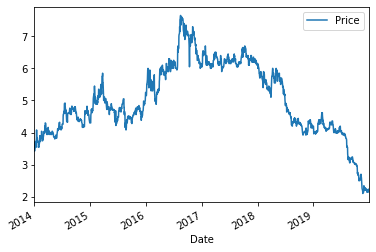

In [25]:
price['AAV'].plot()
price['AAV']

In [26]:
turnover_va['AAV']

,VA
Date,
2019-01-01,NA
2019-01-02,37363.6
2019-01-03,82412.4
2019-01-04,75351.8
2019-01-07,30869.7
...,...
2014-12-25,105279
2014-12-26,147574
2014-12-29,296742


In [27]:
(turnover_va['AAV']['VA'] == 'NA').sum()

100

In [28]:
(price['AAV']['Price']=='NA').sum()

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


0

In [29]:
df = price['AAV']
df['VA'] = turnover_va['AAV']
df['VO'] = turnover_vo['AAV']
df['MV'] = market_val['AAV']
df['PE'] = per_data['AAV']
df['DY'] = dy_data['AAV']
df['DIPE'] = dipe_data['AAV']
df = df.sort_index()
df

,Price,VA,VO,MV,PE,DY,DIPE
Date,,,,,,,
2014-01-01,3.66,NA,NA,17751.00,14.5,0.00,12.11
2014-01-02,3.44,65373.3,19045.1,16683.99,13.6,0.00,12.11
2014-01-03,3.42,34585.3,10163.8,16586.99,13.5,0.00,12.11
2014-01-06,3.54,41467.2,11936.8,17168.99,14,0.00,12.11
2014-01-07,3.72,92143.9,25572,18041.99,14.7,0.00,12.11
...,...,...,...,...,...,...,...
2019-12-25,2.16,3756.8,1739.2,10476.00,NA,15.51,13.38
2019-12-26,2.16,5533.2,2558.2,10476.00,NA,15.51,13.38
2019-12-27,2.20,10248.2,4667.2,10669.99,NA,15.23,13.38


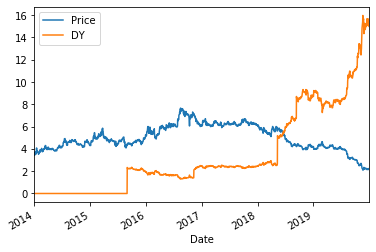

In [30]:
# Check data loaded from Eikon
df[['Price', 'DY']].plot()

In [31]:
df

,Price,VA,VO,MV,PE,DY,DIPE
Date,,,,,,,
2014-01-01,3.66,NA,NA,17751.00,14.5,0.00,12.11
2014-01-02,3.44,65373.3,19045.1,16683.99,13.6,0.00,12.11
2014-01-03,3.42,34585.3,10163.8,16586.99,13.5,0.00,12.11
2014-01-06,3.54,41467.2,11936.8,17168.99,14,0.00,12.11
2014-01-07,3.72,92143.9,25572,18041.99,14.7,0.00,12.11
...,...,...,...,...,...,...,...
2019-12-25,2.16,3756.8,1739.2,10476.00,NA,15.51,13.38
2019-12-26,2.16,5533.2,2558.2,10476.00,NA,15.51,13.38
2019-12-27,2.20,10248.2,4667.2,10669.99,NA,15.23,13.38


In [32]:
len(tickers)

163

# Process all 150 stocks

In [92]:
os.chdir(os.environ['DATA_HOME'])
def get_df_old(t):
    df = pd.concat([price[t], 
                    turnover_va[t], 
                    turnover_vo[t], 
                    market_val[t], 
                    dy_data[t]], axis=1)
    return df[['Price', 'MV', 'VA', 'VO', 'DY']]


def get_df(t):
    df_price = price[t]
    df_va = turnover_va[t]
    df_vo = turnover_vo[t]
    df_mv = market_val[t]
    df_dy = dy_data[t]

    # pd.concat([price['BIG'], turnover_va['BIG']], axis=1)
    df2 =  df_price.merge(df_va, how="left", left_on=df_price.index, right_on=df_va.index)
    df2 = df2.set_index('key_0')
    df2 = df2.sort_index()
    df2 = df2.merge(df_vo, how="left", left_on=df2.index, right_on=df_vo.index)
    df2 = df2.set_index('key_0')
    df2 = df2.sort_index()
    df2 = df2.merge(df_mv, how="left", left_on=df2.index, right_on=df_mv.index)
    df2 = df2.set_index('key_0')
    df2 = df2.sort_index()
    df2 = df2.merge(df_dy, how="left", left_on=df2.index, right_on=df_dy.index)
    df2 = df2.set_index('key_0')
    df2 = df2.sort_index()
    df2.index.rename('Date', inplace=True)
    return df2[['Price', 'MV', 'VA', 'VO', 'DY']]


for t in tickers:
    print("Preparing %s" % t)
    try:
        df = get_df(t)
        df = df.sort_index()
        df.to_csv('set100.data/%s.csv' % t)
        print("wrote %s." % t)
    except KeyError:
        print("No data %s" % t)

Preparing CPALL
wrote CPALL.
Preparing ADVANC
wrote ADVANC.
Preparing BLAND
wrote BLAND.
Preparing GPSC
wrote GPSC.
Preparing TTW
wrote TTW.
Preparing PRM
wrote PRM.
Preparing CBG
wrote CBG.
Preparing VGI
wrote VGI.
Preparing SAPPE
wrote SAPPE.
Preparing TUF
No data TUF
Preparing MONO
wrote MONO.
Preparing MEGA
wrote MEGA.
Preparing ORI
wrote ORI.
Preparing DEMCO
wrote DEMCO.
Preparing SAMART
wrote SAMART.
Preparing LHFG
wrote LHFG.
Preparing GLOBAL
wrote GLOBAL.
Preparing MAJOR
wrote MAJOR.
Preparing KTIS
wrote KTIS.
Preparing BGRIM
wrote BGRIM.
Preparing THAI
wrote THAI.
Preparing BEC
wrote BEC.
Preparing SF
wrote SF.
Preparing TTCL
wrote TTCL.
Preparing VIBHA
wrote VIBHA.
Preparing PSL
wrote PSL.
Preparing SGP
wrote SGP.
Preparing GOLD
wrote GOLD.
Preparing RS
wrote RS.
Preparing TPIPL
wrote TPIPL.
Preparing BH
wrote BH.
Preparing MC
wrote MC.
Preparing BTS
wrote BTS.
Preparing HEMRAJ
No data HEMRAJ
Preparing AEONTS
wrote AEONTS.
Preparing LPN
wrote LPN.
Preparing DTAC
wrote DTAC.
P

In [50]:
pd.concat([price['BLAND'], turnover_va['BLAND'], turnover_vo['BLAND'], market_val['BLAND'], dy_data['BLAND']], axis=1)
# get_df('BLAND')

,Price,VA,VO,MV,DY
Date,,,,,
2019-01-01,1.51,NA,NA,28080.85,5.96
2019-01-02,1.54,15528.8,10143.9,28638.74,5.84
2019-01-03,1.53,15911.3,10329.3,28452.77,5.88
2019-01-04,1.54,8539.9,5584.2,28638.74,5.84
2019-01-07,1.57,16167.2,10368.2,29196.64,5.73
...,...,...,...,...,...
2014-12-25,1.61,83831.5,51836.3,33266.32,3.73
2014-12-26,1.62,53799.3,33380.4,33472.95,3.70
2014-12-29,1.59,57141.9,35609.2,32853.09,3.77


In [91]:
pd.concat([price['BIG'], market_val['BIG'], dy_data['BIG']], axis=1)
# get_df('BIG') 

df_price = price['BIG']
df_va = turnover_va['BIG']
df_vo = turnover_vo['BIG']
df_mv = market_val['BIG']
df_dy = dy_data['BIG']

# pd.concat([price['BIG'], turnover_va['BIG']], axis=1)
df2 =  df_price.merge(df_va, how="left", left_on=df_price.index, right_on=df_va.index)
df2 = df2.set_index('key_0')
df2 = df2.sort_index()
df2 = df2.merge(df_vo, how="left", left_on=df2.index, right_on=df_vo.index)
df2 = df2.set_index('key_0')
df2 = df2.sort_index()
df2 = df2.merge(df_mv, how="left", left_on=df2.index, right_on=df_mv.index)
df2 = df2.set_index('key_0')
df2 = df2.sort_index()
df2 = df2.merge(df_dy, how="left", left_on=df2.index, right_on=df_dy.index)
df2 = df2.set_index('key_0')
df2 = df2.sort_index()
df2.index.rename('Date', inplace=True)

df2

,Price,VA,VO,MV,DY
Date,,,,,
2014-01-01,1.25,NaN,NaN,50.67,0.00
2014-01-02,1.25,NaN,NaN,50.67,0.00
2014-01-03,1.25,NaN,NaN,50.67,0.00
2014-01-06,1.25,NaN,NaN,50.67,0.00
2014-01-07,1.25,NaN,NaN,50.67,0.00
...,...,...,...,...,...
2019-12-25,0.51,648,1270.5,1799.73,15.69
2019-12-26,0.52,811.3,1590.2,1835.02,15.38
2019-12-27,0.51,950.8,1836.5,1799.73,15.69


In [77]:
# U missing PER data
# UV missing DIPE data
# WHAUP missing PER data

get_df('WHAUP') 

,Price,MV,VA,VO,DY
Date,,,,,
2019-01-01,5.55,21228.7,NA,NA,3.66
2019-01-02,5.60,21420,16069.6,2870.1,3.63
2019-01-03,5.55,21228.7,9111.3,1633,3.66
2019-01-04,5.55,21228.7,30266.7,5525.9,3.66
2019-01-07,5.65,21611.2,21106.2,3757.6,3.6
...,...,...,...,...,...
2017-12-25,7.80,29835,67250.4,8666.7,0
2017-12-26,7.85,30026.2,75215,9661.2,0
2017-12-27,8.10,30982.5,274822,34327.2,0


In [47]:
pd.concat([price['CBG'], turnover_va['CBG'], turnover_vo['CBG'], market_val['CBG'], dy_data['CBG']], axis=1)

,Price,VA,VO,MV,DY
Date,,,,,
2019-01-01,30.75,NA,NA,30750,2.28
2019-01-02,31.25,151218,4853.8,31250,2.24
2019-01-03,30.75,55944.4,1801,30750,2.28
2019-01-04,33.00,162982,5160.3,33000,2.12
2019-01-07,33.75,123216,3663.5,33750,2.07
...,...,...,...,...,...
2014-12-25,32.75,31577.2,959.8,32750,0
2014-12-26,33.25,25537.5,779.4,33250,0
2014-12-29,33.00,13017.1,394.2,33000,0


In [41]:
pd.concat([price['CBG'], turnover_va['CBG'], turnover_vo['CBG'], 
           market_val['CBG'], dy_data['CBG'], per_data['CBG'], 
           dipe_data['CBG']], axis=1, sort=False)

# df2 = dipe_data['BLAND']
# df['DIPE'] = dipe_data['BLAND'].sort_index()

# df_out = pd.merge(df1,df2, left_on=df1.index, right_on=df2.index, how='left')
# df_out


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
price.keys()

# per_data['CBG'].plot()

In [ ]:
df1 = price['BLAND']
df2 = dipe_data['BLAND']
df_tmp = pd.merge(df1,df2, left_on=df1.index, right_on=df2.index, how='left')
df_tmp

In [ ]:


# df_tmp.index = df1.index
df3 = turnover_va['BLAND']
df4 = turnover_vo['BLAND']
df_tmp2 = pd.merge(df3,df4, left_on=df3.index, right_on=df4.index, how='left')
# df_tmp2.index = df3.index

df5 = market_val['BLAND']
df6 = per_data['BLAND']
df_tmp3 = pd.merge(df5,df6, left_on=df5.index, right_on=df6.index, how='left')
# df_tmp3.index = df5.index

df_tmp4 = pd.merge(df_tmp, df_tmp2, left_on=df_tmp.index, right_on=df_tmp2.index, how='left')


df_tmp5 = pd.merge(df_tmp4, df_tmp3, left_on=df_tmp4.index, right_on=df_tmp3.index, how='left')



df_tmp5

In [ ]:
price['BIG']

In [ ]:
turnover_va['BIG'].sort_index()

In [ ]:
market_val['MBK']